<a href="https://colab.research.google.com/github/errpv78/Hacktoberfest_ML/blob/main/Covid_19TweetsAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysing covid-19 tweets
Dataset: Tweets started collecting from 25-07-2020, with #covid19 involved.

### Analysis Performed by: Parikh Goyal
parikhgoyal13@gmail.com

## Approach
1. Opening the columns.txt and understanding the columns their types and description.
2. Loading the dataset and viewing its sample, dimensions and a sample row.
3. Checking Frequency distribution and description in integer columns like user_followers, user_friends.
4. Checking for null and missing values and cleaning the data.
5. Exploring the unique values in columns their frequency and maximum lengths of columns to understand more about distribution of data.
6. Filtering columns to get relevant information needed for better grouping and understanding data like adding tweet_date for date of tweetcolumn from date column which had both date and time to look for frequency distribution of tweets date wise.
7. Plotting tweet lengths to see variation of tweet lengths in words.
8. Building and training sentimental analysis Bert model, link for separate training file included below.
9. Preprocessing the tweet text to filter out unnecessary words and characters and adding sentiment column to dataframe and saving dataframe to a new csv file.
10. Checking overall sentiment distribution among tweets.
11. Subsetting dataframe with conditions on columns to understand distribution among columns.
12. Visualizing sentiments among top values and frequency distribution of sentiments with respect to other columns.
13. Exploring hashtags column to understand different hashtags and their relation with sentiments and other columns.


## Insights

* Tweets have been done by different people and count of tweets is high for government bodies and news forums like GlobalPandemic.NET, Coronavirus Updates, covidnews.ch, Open Letters, Blood Donors India.

* Most tweets are from users with location India (3741 (India) + 1721 (New delhi, India) + 1401 (Mumbai, India) +..) followed by USA (2455 + 1354 + ..)
 
* More than 87% users are not verified
 
* None of the tweet was retweeted so column is_retweeted is of less importance.

* Only 9 locations with no of tweets greater than 1000 Most locations have tweets less than 100.

* Most tweets had positive sentiment; Positive:Negative = 2.965

* The most no of negative tweets were from user_name Blood Donors, followed by Covid Scale.

* Among top10 users with most tweets user_name Blood Donors has remarkably high ratio of negative to positive tweets.

* Most number of positive tweets were done by GlobalPandemic.NET followed by Coronavirus Updates user_names.

* No of positive tweets on every day were greater than negative tweets by greater than 50% consistently.

* Most tweets among top 10 locations with most tweets overall were on 2020-07-25 followed by 2020-08-22.

* 2020-07-25 has most no of positive as well as negative tweets.

* Among Top 10 locations with most tweets, all locations has positive no of tweets more than 50% of negative number of tweets.

* Positive negative tweets ratio with India in user_location was slighly increased to 3.01 from overall 2.96

* Positive negative tweets ratio with US in user_location is drops to 2.46 from overall 2.96.

* covid19, coronavirus were among the most popular hashtags used

* Trump was the most popular hashtags used among persons.

* The negative-positive tweet ratio is slightly dropped to 2.73 from overall 2.965 in tweets that involved trump as hashtag.

* The negative-positive tweet ratio is remarkably increased to 4.77 from overall 2.97
in tweets with India in user_location.

* Most users used twitter web app than android than iphone as source.
 
* Most tweets are on 2020-07-25, all tweets are distributed among 26 days.

* Mostly frequency of tweets were consistent with some rise early and later and some drops in middle, however mostly consistent, Around 7500 tweets daily.

* A bell shaped curve for no of words in tweet.
Majority of tweets are 15-25 words.

* Trump hashtag was much used in US and has more positive tweets involoved with similar ratio as of global.

* The positive negative ratio in tweets from top5 sources is similar to overall average.

* The Positive to negative tweet ratio is similar among verified and non verified users.









In [ ]:
!pip install transformers

In [ ]:
# Importing necessary libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from PIL import Image
import cv2
import os
import imutils
import numpy as np
from tqdm.notebook import tqdm

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Getting the data

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

# Make dataset folder
!mkdir dataset

# Move data from drive
!cp gdrive/My\ Drive/First\ round\ -\ DS\ intern/columns.txt dataset/
!cp gdrive/My\ Drive/First\ round\ -\ DS\ intern/dataset.zip dataset/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
mkdir: cannot create directory ‘dataset’: File exists


In [ ]:
!unzip dataset/dataset.zip -d dataset

In [ ]:
!ls dataset/

columns.txt  covid19_tweets.csv  dataset.zip


## Viewing dataset

In [ ]:
# Reading columns file
f = open('dataset/columns.txt', 'r')
text = f.read()
text

"user_name -> Twitter User user_name\nuser_location -> User's location\nuser_description -> User's bio/description\nuser_created -> When was the user created\nuser_followers -> number of followers of this user\nuser_friends -> number of friends of this user\nuser_favourites -> number of favourites for this user\nuser_verified -> is this user verified\ndate -> tweet date\ntext -> text of the tweet\nhashtags -> list of hashtags used\nsource -> Source of the tweet\nis_retweet -> The tweet is a retweet\n"

In [ ]:
# Getting individual columns values and their description
lines = text.split('\n')
lines

['user_name -> Twitter User user_name',
 "user_location -> User's location",
 "user_description -> User's bio/description",
 'user_created -> When was the user created',
 'user_followers -> number of followers of this user',
 'user_friends -> number of friends of this user',
 'user_favourites -> number of favourites for this user',
 'user_verified -> is this user verified',
 'date -> tweet date',
 'text -> text of the tweet',
 'hashtags -> list of hashtags used',
 'source -> Source of the tweet',
 'is_retweet -> The tweet is a retweet',
 '']

In [ ]:
# Getting columns of dataset
columns = []
for i in lines[:-1]:
    columns.append(i.split('->')[0].strip())
columns    

['user_name',
 'user_location',
 'user_description',
 'user_created',
 'user_followers',
 'user_friends',
 'user_favourites',
 'user_verified',
 'date',
 'text',
 'hashtags',
 'source',
 'is_retweet']

In [ ]:
# Reading the dataset
df = pd.read_csv('dataset/covid19_tweets.csv')
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


In [ ]:
# Looking at last 10 rows of dataset
df.tail()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
179103,AJIMATI AbdulRahman O.,"Ilorin, Nigeria",Animal Scientist|| Muslim|| Real Madrid/Chelsea,2013-12-30 18:59:19,412,1609,1062,False,2020-08-29 19:44:21,Thanks @IamOhmai for nominating me for the @WH...,['WearAMask'],Twitter for Android,False
179104,Jason,Ontario,When your cat has more baking soda than Ninja ...,2011-12-21 04:41:30,150,182,7295,False,2020-08-29 19:44:16,2020! The year of insanity! Lol! #COVID19 http...,['COVID19'],Twitter for Android,False
179105,BEEHEMOTH ⏳,🇨🇦 Canada,⚒️ The Architects of Free Trade ⚒️ Really Did ...,2016-07-13 17:21:59,1623,2160,98000,False,2020-08-29 19:44:15,@CTVNews A powerful painting by Juan Lucena. I...,NaN,Twitter Web App,False
179106,Gary DelPonte,New York City,"Global UX UI Visual Designer. StoryTeller, Mus...",2009-10-27 17:43:13,1338,1111,0,False,2020-08-29 19:44:14,"More than 1,200 students test positive for #CO...",['COVID19'],Twitter for iPhone,False
179107,TUKY II,"Aliwal North, South Africa",TOKELO SEKHOPA | TUKY II | LAST BORN | EISH TU...,2018-04-14 17:30:07,97,1697,566,False,2020-08-29 19:44:08,I stop when I see a Stop\n\n@SABCNews\n@Izinda...,NaN,Twitter for Android,False


In [ ]:
# Dimensions of dataset
df.shape
# Inference: dataset has 13 columns and 179108 columns

(179108, 13)

In [ ]:
# Description about dataset
df.describe()
# Inference: Maxm user followers are ~ 50 million

,user_followers,user_friends,user_favourites
count,1.791080e+05,179108.000000,1.791080e+05
mean,1.090555e+05,2121.701566,1.444411e+04
std,8.414670e+05,9162.553072,4.452270e+04
min,0.000000e+00,0.000000,0.000000e+00
25%,1.720000e+02,148.000000,2.060000e+02
50%,9.920000e+02,542.000000,1.791000e+03
75%,5.284000e+03,1725.250000,9.388000e+03
max,4.944256e+07,497363.000000,2.047197e+06


In [ ]:
# Checking for null values
df.isna().sum()
# Inference: Most null values are from hashtags followed by user location followed by user description.

user_name               0
user_location       36771
user_description    10286
user_created            0
user_followers          0
user_friends            0
user_favourites         0
user_verified           0
date                    0
text                    0
hashtags            51334
source                 77
is_retweet              0
dtype: int64

In [ ]:
# Replacing NaN values with empty string
rep_with_empty = ['user_location', 'user_description', 'hashtags', 'source']

for i, row in tqdm(df.iterrows()):
    for j in rep_with_empty:
        col = df.loc[i, j]
        if 'float' in str(type(col)):
            df.at[i, j] = ''

    for j in rep_with_zero:
        col = df.loc[i, j]
        try:
            df.at[i, j] = int(df.at[i, j])
        except:
            df.at[i, j] = 0
            
print(df.isna().sum())


user_name           0
user_location       0
user_description    0
user_created        0
user_followers      0
user_friends        0
user_favourites     0
user_verified       0
date                0
text                0
hashtags            0
source              0
is_retweet          0
dtype: int64


In [ ]:
# A sample row
df.iloc[78]

user_name                                         Oxfam International
user_location                                                        
user_description    Oxfam is a world-wide development organization...
user_created                                      2007-12-31 18:27:35
user_followers                                                 843670
user_friends                                                     1172
user_favourites                                                 23652
user_verified                                                    True
date                                              2020-07-25 12:25:00
text                “#Covid19 is everyone’s fight. I have covered ...
hashtags                                                  ['Covid19']
source                                                Twitter Web App
is_retweet                                                      False
Name: 78, dtype: object

In [ ]:
# Checking number of unique values
df.nunique()

user_name            92276
user_location        26921
user_description     89201
user_created         93708
user_followers       27694
user_friends         11022
user_favourites      35259
user_verified            2
date                136611
text                178683
hashtags             52641
source                 611
is_retweet               1
dtype: int64

In [ ]:
# Finding maximum lengths of columns(characters)
column_lengths = np.vectorize(len)
max_column_lenghts = column_lengths(df.values.astype(str)).max(axis=0)
print('Max Column Lengths:')
for i in range(len(columns)):
    print(columns[i], ":", max_column_lenghts[i])

Max Column Lengths:
user_name : 50
user_location : 145
user_description : 264
user_created : 19
user_followers : 8
user_friends : 6
user_favourites : 7
user_verified : 5
date : 19
text : 169
hashtags : 146
source : 32
is_retweet : 5


In [ ]:
# Function for exploring unique values in columns
def check_unique(column):
    print(f"For {column}:")
    # No of unique values
    print(f"The no of unique values: {len(df[column].unique())}\n")

    # Some unique values 
    print(f"Unique values: \n{df[column].unique()[:5]}")

    # Frequency of each unique value in that column
    print(f"Unique value count: \n{df[column].value_counts()}\n")

In [ ]:
# Checking unique values in columns
columns_to_check_unique = [
 'user_name',
 'user_location',
 'user_description',
 'user_created',
 'user_followers',
 'user_friends',
 'user_favourites',
 'user_verified',
 'date',
 'text',
 'hashtags',
 'source',
 'is_retweet']

for col in columns_to_check_unique:
    check_unique(col)
    print("\n\n")

# Inference: Tweets have been done by different people and count of tweets is high for government bodies and news forums like GlobalPandemic.NET, Coronavirus Updates.
# covidnews.ch, Open Letters, Blood Donors India 
# 
# Most tweets are from India (3741 (India) + 1721 (New delhi, India) + 1401 (Mumbai, India) +..) followed by USA (2455 + 1354 + ..)
# 
# Nothing much important to infer from unique value analysis of columns user_description, user_created, user_folowwers, user_friends, user_favourites,
# text, hashtags, 
# 
# More than 87% users are not verified
# 
# Tweet date is associated with time so unique values are less but time can be filetered out to dates can be grouped to get better insights.
# 
# Most users used twitter web app than android than iphone as source.
# 
# None of the tweet was retweeted so column is_retweeted is of less importance.

For user_name:
The no of unique values: 92276

Unique values: 
['ᏉᎥ☻լꂅϮ' 'Tom Basile 🇺🇸' 'Time4fisticuffs' 'ethel mertz' 'DIPR-J&K']
Unique value count: 
GlobalPandemic.NET                679
Coronavirus Updates               625
covidnews.ch                      402
Open Letters                      390
Blood Donors India                282
                                 ... 
Abu Saarim                          1
David Tucker                        1
Dev D 😎                             1
Henrietta Ighomrore                 1
Nation of Kekistan in Portland      1
Name: user_name, Length: 92276, dtype: int64




For user_location:
The no of unique values: 26921

Unique values: 
['astroworld' 'New York, NY' 'Pewee Valley, KY' 'Stuck in the Middle '
 'Jammu and Kashmir']
Unique value count: 
                          36771
India                      3741
United States              2455
New Delhi, India           1721
Mumbai, India              1401
                          ...  
Leomin

In [ ]:
# Exploring user_location
loc = df['user_location'].value_counts()

# Locations with over 1000 entries
print(sum(loc[loc>1000])) # Total entries: 15332
print(len(loc[loc>1000])) # No of locaions: 9

# Locations with over 500 entries
print(sum(loc[loc>500])) # Total entries: 15332
print(len(loc[loc>500])) # No of locaions: 28

# Locations with less than 100 entries
print(sum(loc[loc<100])) # Total entries: 82519
print(len(loc[loc<100])) # No of locaions: 26741

# Locations with less than 10 entries
print(sum(loc[loc<10])) # Total entries: 45121
print(len(loc[loc<10])) # No of locaions: 25271

# Inference: Only 9 locations with no of tweets greater than 1000
# Most locations have tweets less than 100

52103
10
65596
29
82519
26741
45121
25271


In [ ]:
# Exploring user_followers
fol = df['user_followers']

# Users with more than 1 crore
print(len(fol[fol>10000000])) # 396

# Users with more than 1 million
print(len(fol[fol>1000000])) # 3433

# Users with more than 1 lakh
print(len(fol[fol>100000])) # 9744

# Users with more than 10,000
print(len(fol[fol>10000])) # 33,097

# Users with more than 1000
print(len(fol[fol<1000])) # 89,701

# Users with more than 100
print(len(fol[fol<100])) # 33,991

396
3433
9744
33097
89701
33991


In [ ]:
# Exploring user_friends
friends = df['user_friends']

# Users with more than 1 lakh
print(len(friends[friends>100000])) # 163

# Users with more than 10,000
print(len(friends[friends>10000])) # 5977

# Users with more than 1000
print(len(friends[friends>1000])) # 64422

# Users with more than 100
print(len(friends[friends>100])) # 143237

# Users with more than 10
print(len(friends[friends<10])) # 9972

163
5977
64422
143237
9972


In [ ]:
# Filtering and grouping date
tweet_date = df.loc[:,'date']
tweet_date = tweet_date.str.split(expand=True)
df['tweet_date'] = tweet_date.iloc[:,0]
df.head(5)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,tweet_date
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,,Twitter for iPhone,False,2020-07-25
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,,Twitter for Android,False,2020-07-25
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,2020-07-25
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,2020-07-25
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,2020-07-25


In [ ]:
# Checking tweet dates
check_unique('tweet_date')
# Inference: Most tweets are on 2020-07-25, all tweets are distributed among 26 days

For tweet_date:
The no of unique values: 26

Unique values: 
['2020-07-25' '2020-07-24' '2020-07-26' '2020-07-27' '2020-07-28']
Unique value count: 
2020-07-25    16881
2020-08-22    11555
2020-08-30     8375
2020-08-04     7500
2020-08-08     7500
2020-08-13     7500
2020-08-09     7500
2020-08-16     7500
2020-08-18     7500
2020-07-27     7500
2020-07-31     7500
2020-08-14     7500
2020-07-28     7500
2020-08-02     7500
2020-08-12     7500
2020-07-26     7500
2020-08-17     7500
2020-08-11     7500
2020-08-01     7500
2020-08-06     7214
2020-08-10     4891
2020-08-29     4077
2020-07-29     2780
2020-07-30     1980
2020-08-07     1060
2020-07-24      295
Name: tweet_date, dtype: int64



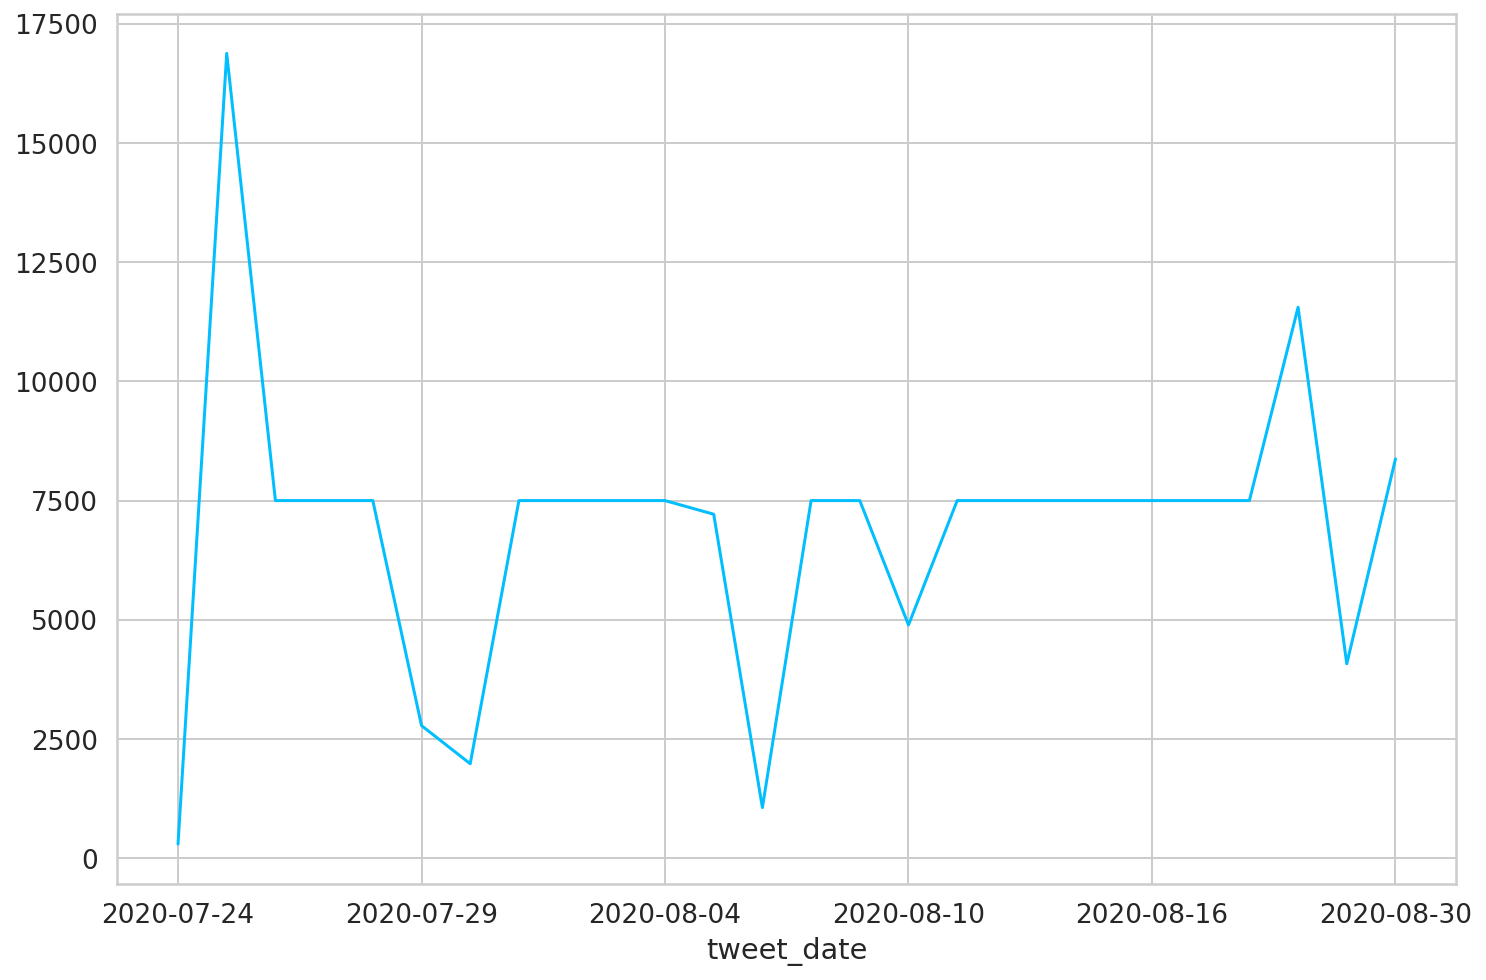

In [ ]:
# Plot of tweets frequency date wise
df.groupby('tweet_date').size().plot()
# Inference: Mostly frequency of tweets were consistent with some rise early and later and some drops in middle, however mostly consistent.

Text(0.5, 0, 'Tweet length')

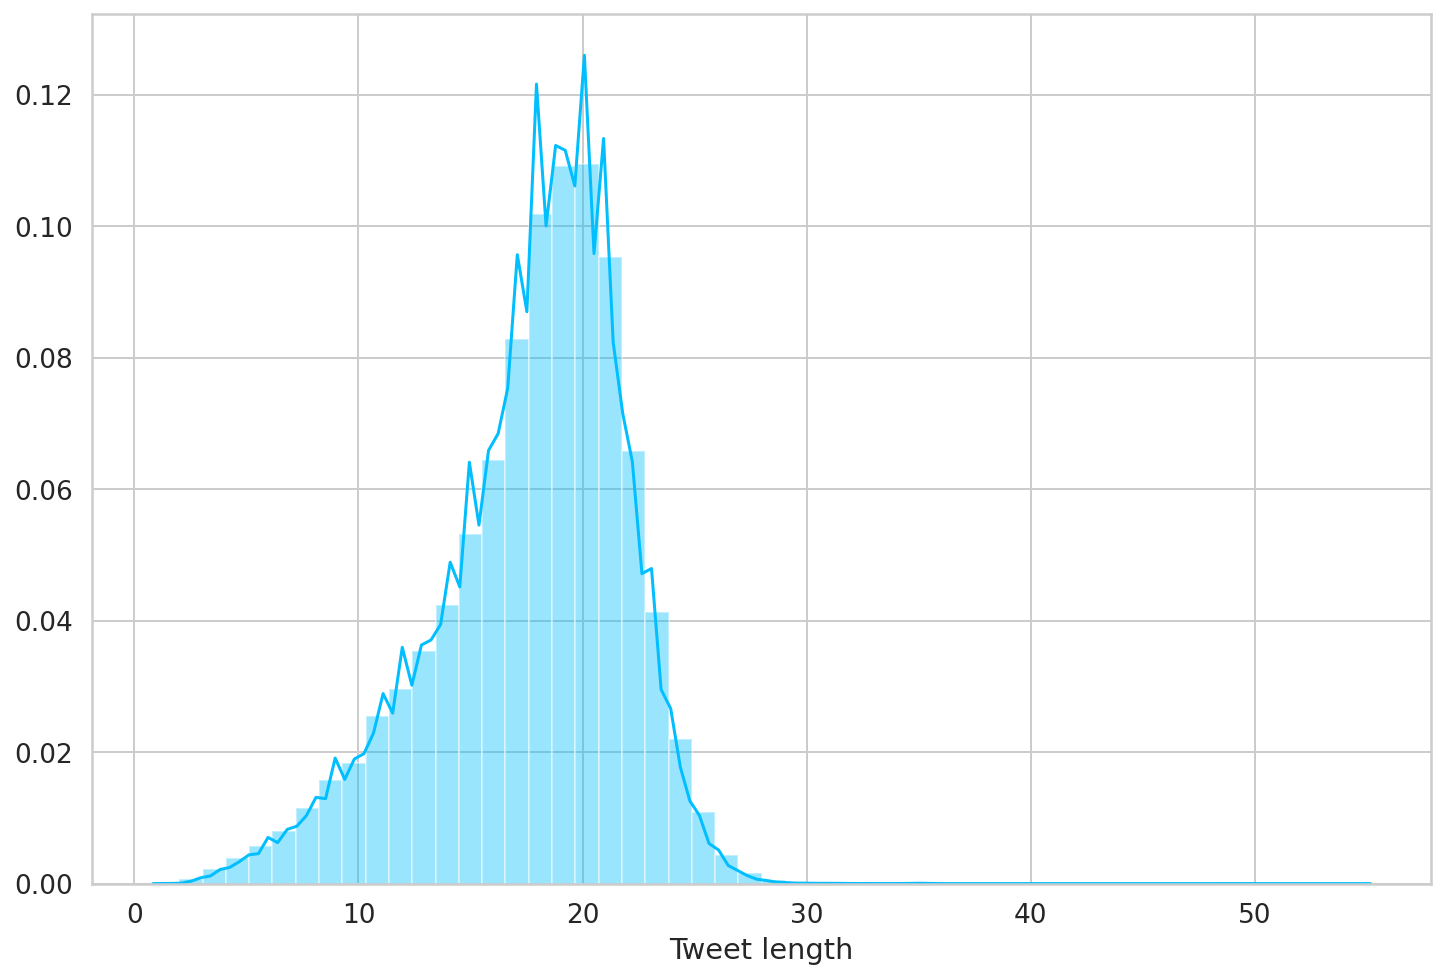

In [ ]:
# Plotting lengths of tweets
tweet_len = []
for tweet in df.text:
    tweet_len.append(len(tweet.split()))

sns.distplot(tweet_len)
# plt.xlim([0, 100]);
plt.xlabel('Tweet length')
# Inference: A bell shaped curve for no of words in tweet.
# Majority of tweets are 15-25 words.

## Predicting sentiments of tweets

Technology used for sentimental analysis: Bert<br>
I have done sentimental analysis before and I have tried a simple neural network, followed by Lstm model followed by Bert so I know Bert is good to use.<br>
Referring to my other project for sentimental analysis bert model training, and will import the rrained model here.<br>
Referred project: https://github.com/errpv78/Detecting_Sentiments_of_Quote <br>
(This is my own project, my github username is errpv78 and profile is: https://github.com/errpv78)

Training process done in separate file, link(viewable): https://colab.research.google.com/drive/1ju9DYBtqNf0v_ALgT9cjTg5GO5513AjI?usp=sharing


In [ ]:
class_names = ['negative', 'positive']
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
MAX_LEN = 100
nltk.download('stopwords')
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
!cp gdrive/My\ Drive/Kaggle/Sentimental_Analysis/best_model_state_50K.bin /content
!ls 

In [ ]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state_50K.bin'))
model = model.to(device)

In [ ]:
df['Sentiment'] = ''
df.head(5)

In [ ]:
# Adding sentiments to tweets
for i, row in tqdm(df.iterrows()):
    text = df.loc[i, 'text']

    # Preprocess text and get model prediction
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    ps = PorterStemmer()
    text = [ps.stem(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    # print(text)
    encoded_text = tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True,
    )
    
    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    
    temp = class_names[prediction]
    # print(temp)
    if temp=='positive':
        df.at[i, 'Sentiment'] = 'Positive'
    else:
        df.at[i, 'Sentiment'] = 'Negative'

In [ ]:
df.head()

In [ ]:
df.to_csv("tweets_with_sentiments.csv")

In [ ]:
!ls

In [ ]:
# Saving df
!cp tweets_with_sentiments.csv gdrive/My\ Drive/Kaggle/Sentimental_Analysis/

## Analysing tweet sentiments

In [ ]:
# Loading dataset with sentiments
df = pd.read_csv('gdrive/My Drive/Kaggle/Sentimental_Analysis/tweets_with_sentiments.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,5,8,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.head(5)

,Unnamed: 0,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,tweet_date,Sentiment
0,0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950.0,18775.0,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,,Twitter for iPhone,False,2020-07-25,Positive
1,1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677.0,24.0,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,,Twitter for Android,False,2020-07-25,Positive
2,2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525.0,7254.0,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,2020-07-25,Positive
3,3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987.0,1488.0,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,2020-07-25,Positive
4,4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168.0,101.0,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,2020-07-25,Positive


In [ ]:
# Replacing NaN values with empty string
rep_with_empty = ['user_name',  'user_location', 'user_description', 'user_created', 'user_verified', 'date',
 'text',
 'hashtags',
 'source',
 'is_retweet']

# Replacing NaN values with 0
rep_with_zero = ['user_followers', 'user_friends', 'user_favourites']

print(df.isna().sum())

for i, row in tqdm(df.iterrows()):
    for j in rep_with_empty:
        col = df.loc[i, j]
        if 'float' in str(type(col)):
            df.at[i, j] = ''

    for j in rep_with_zero:
        col = df.loc[i, j]
        try:
            df.at[i, j] = int(df.at[i, j])
        except:
            df.at[i, j] = 0
            
        
# df.fillna('', inplace=True)
print(df.isna().sum())

Unnamed: 0              0
user_name               2
user_location       36773
user_description    10288
user_created            2
user_followers          2
user_friends            5
user_favourites         5
user_verified           5
date                    5
text                    5
hashtags            51342
source                 85
is_retweet              8
tweet_date              8
Sentiment               8
dtype: int64



Unnamed: 0          0
user_name           0
user_location       0
user_description    0
user_created        0
user_followers      0
user_friends        0
user_favourites     0
user_verified       0
date                0
text                0
hashtags            0
source              0
is_retweet          0
tweet_date          8
Sentiment           8
dtype: int64


Positive    133940
Negative     45165
Name: Sentiment, dtype: int64


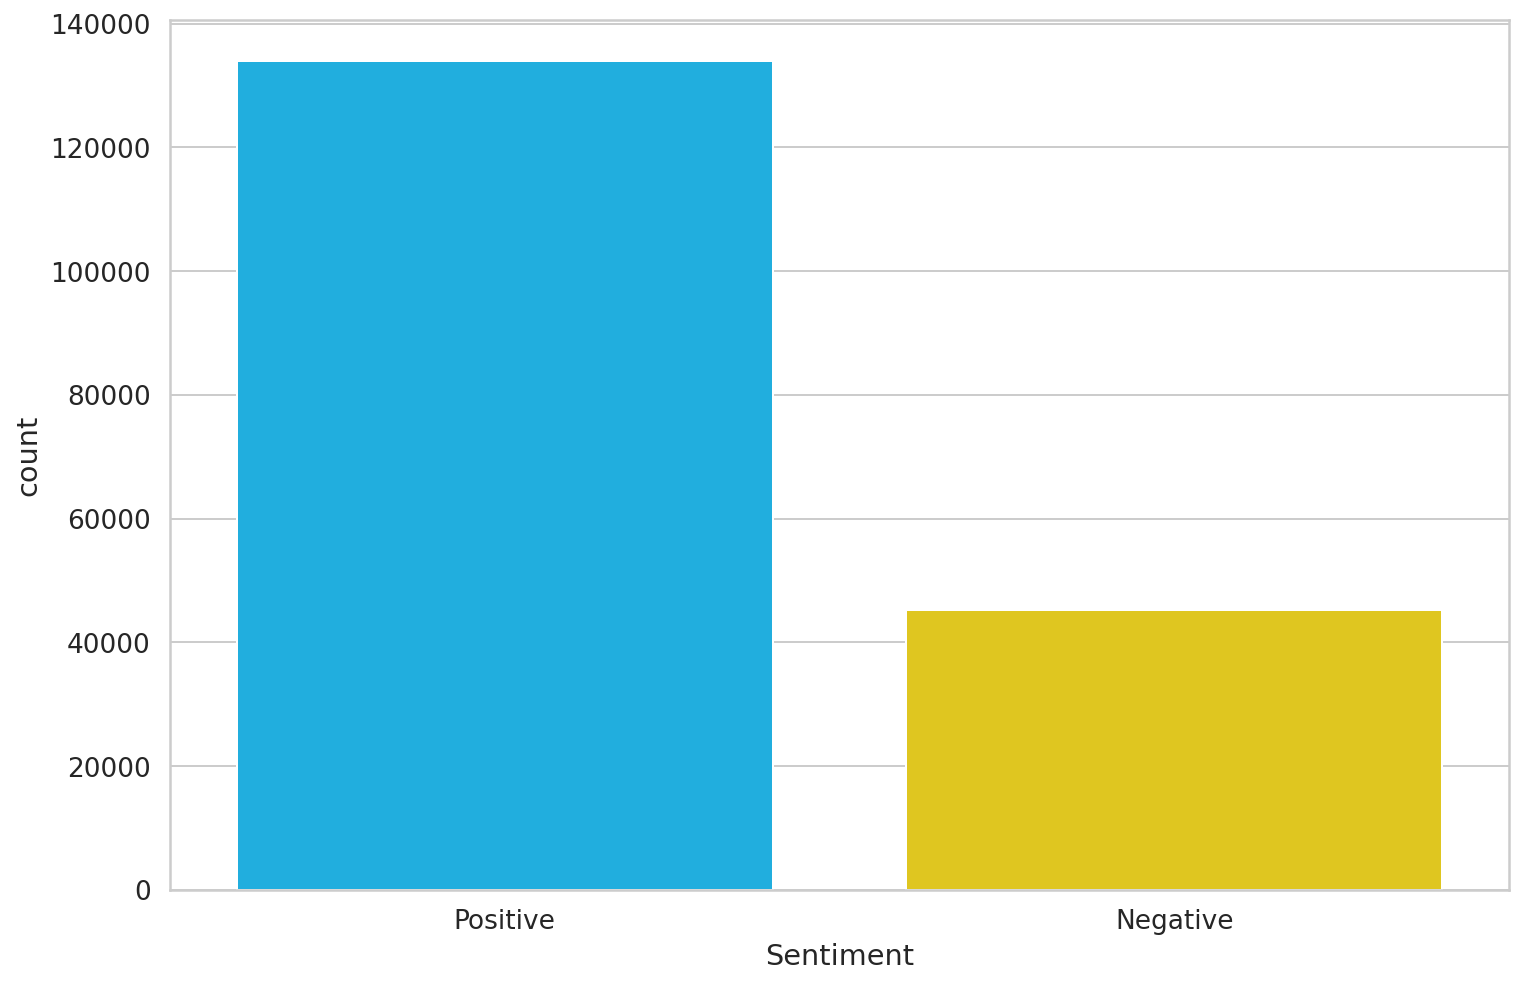

In [ ]:
# Sentiments ratio
print(df['Sentiment'].value_counts()) # Positive: 133940     Negative: 45165

sns.countplot(df.Sentiment)
plt.xlabel('Sentiment');

# Inference: Most tweets had positive sentiment; Positive: = 2.965

India               3741
United States       2455
New Delhi, India    1721
Mumbai, India       1401
Washington, DC      1354
London, England     1269
United Kingdom      1206
London              1103
New York, NY        1082
Australia            964
Name: user_location, dtype: int64


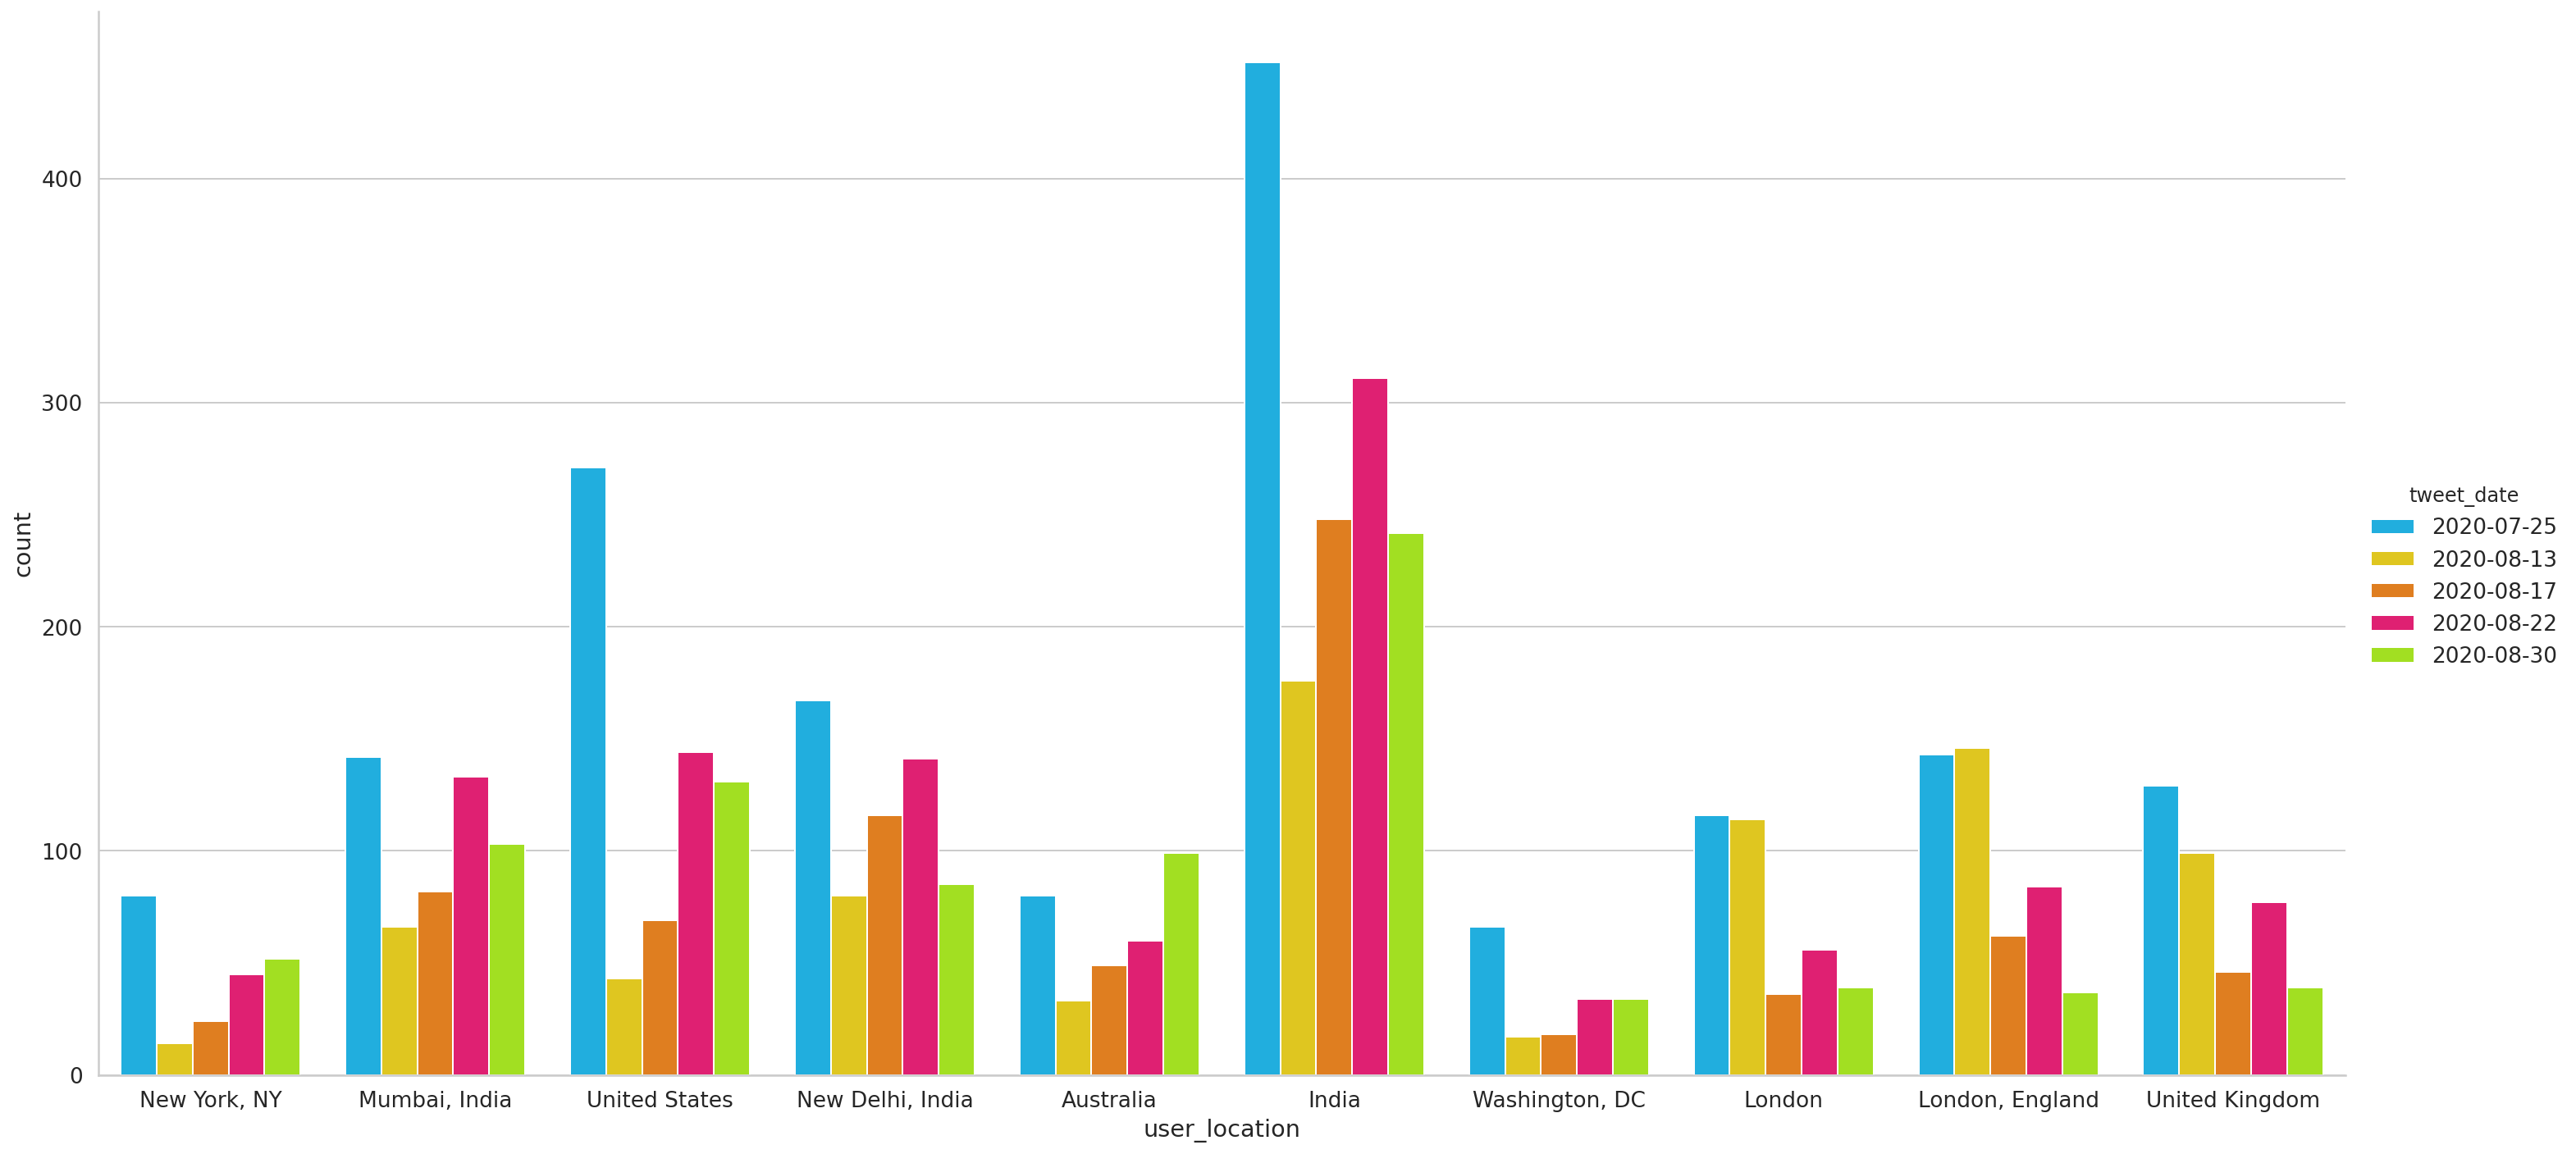

In [ ]:
# Grouping by tweet_date and user location
loc_top10 = df['user_location'].value_counts()[:11]

loc_top10.drop(labels=['',],inplace=True)
print(loc_top10)
df1 = df[df['user_location'].isin(loc_top10.index)]
dates = df1['tweet_date'].value_counts()[:5]
df2 = df1[df1['tweet_date'].isin(dates.index)]

temp = df2.groupby(['tweet_date', 'user_location']).size()
# # temp

sns.catplot(data=df2,kind='count',x='user_location',hue='tweet_date', height=10, aspect=2)
# Inference: Most tweets among top 10 locations with most tweets overall were on 2020-07-25 followed by 2020-08-22

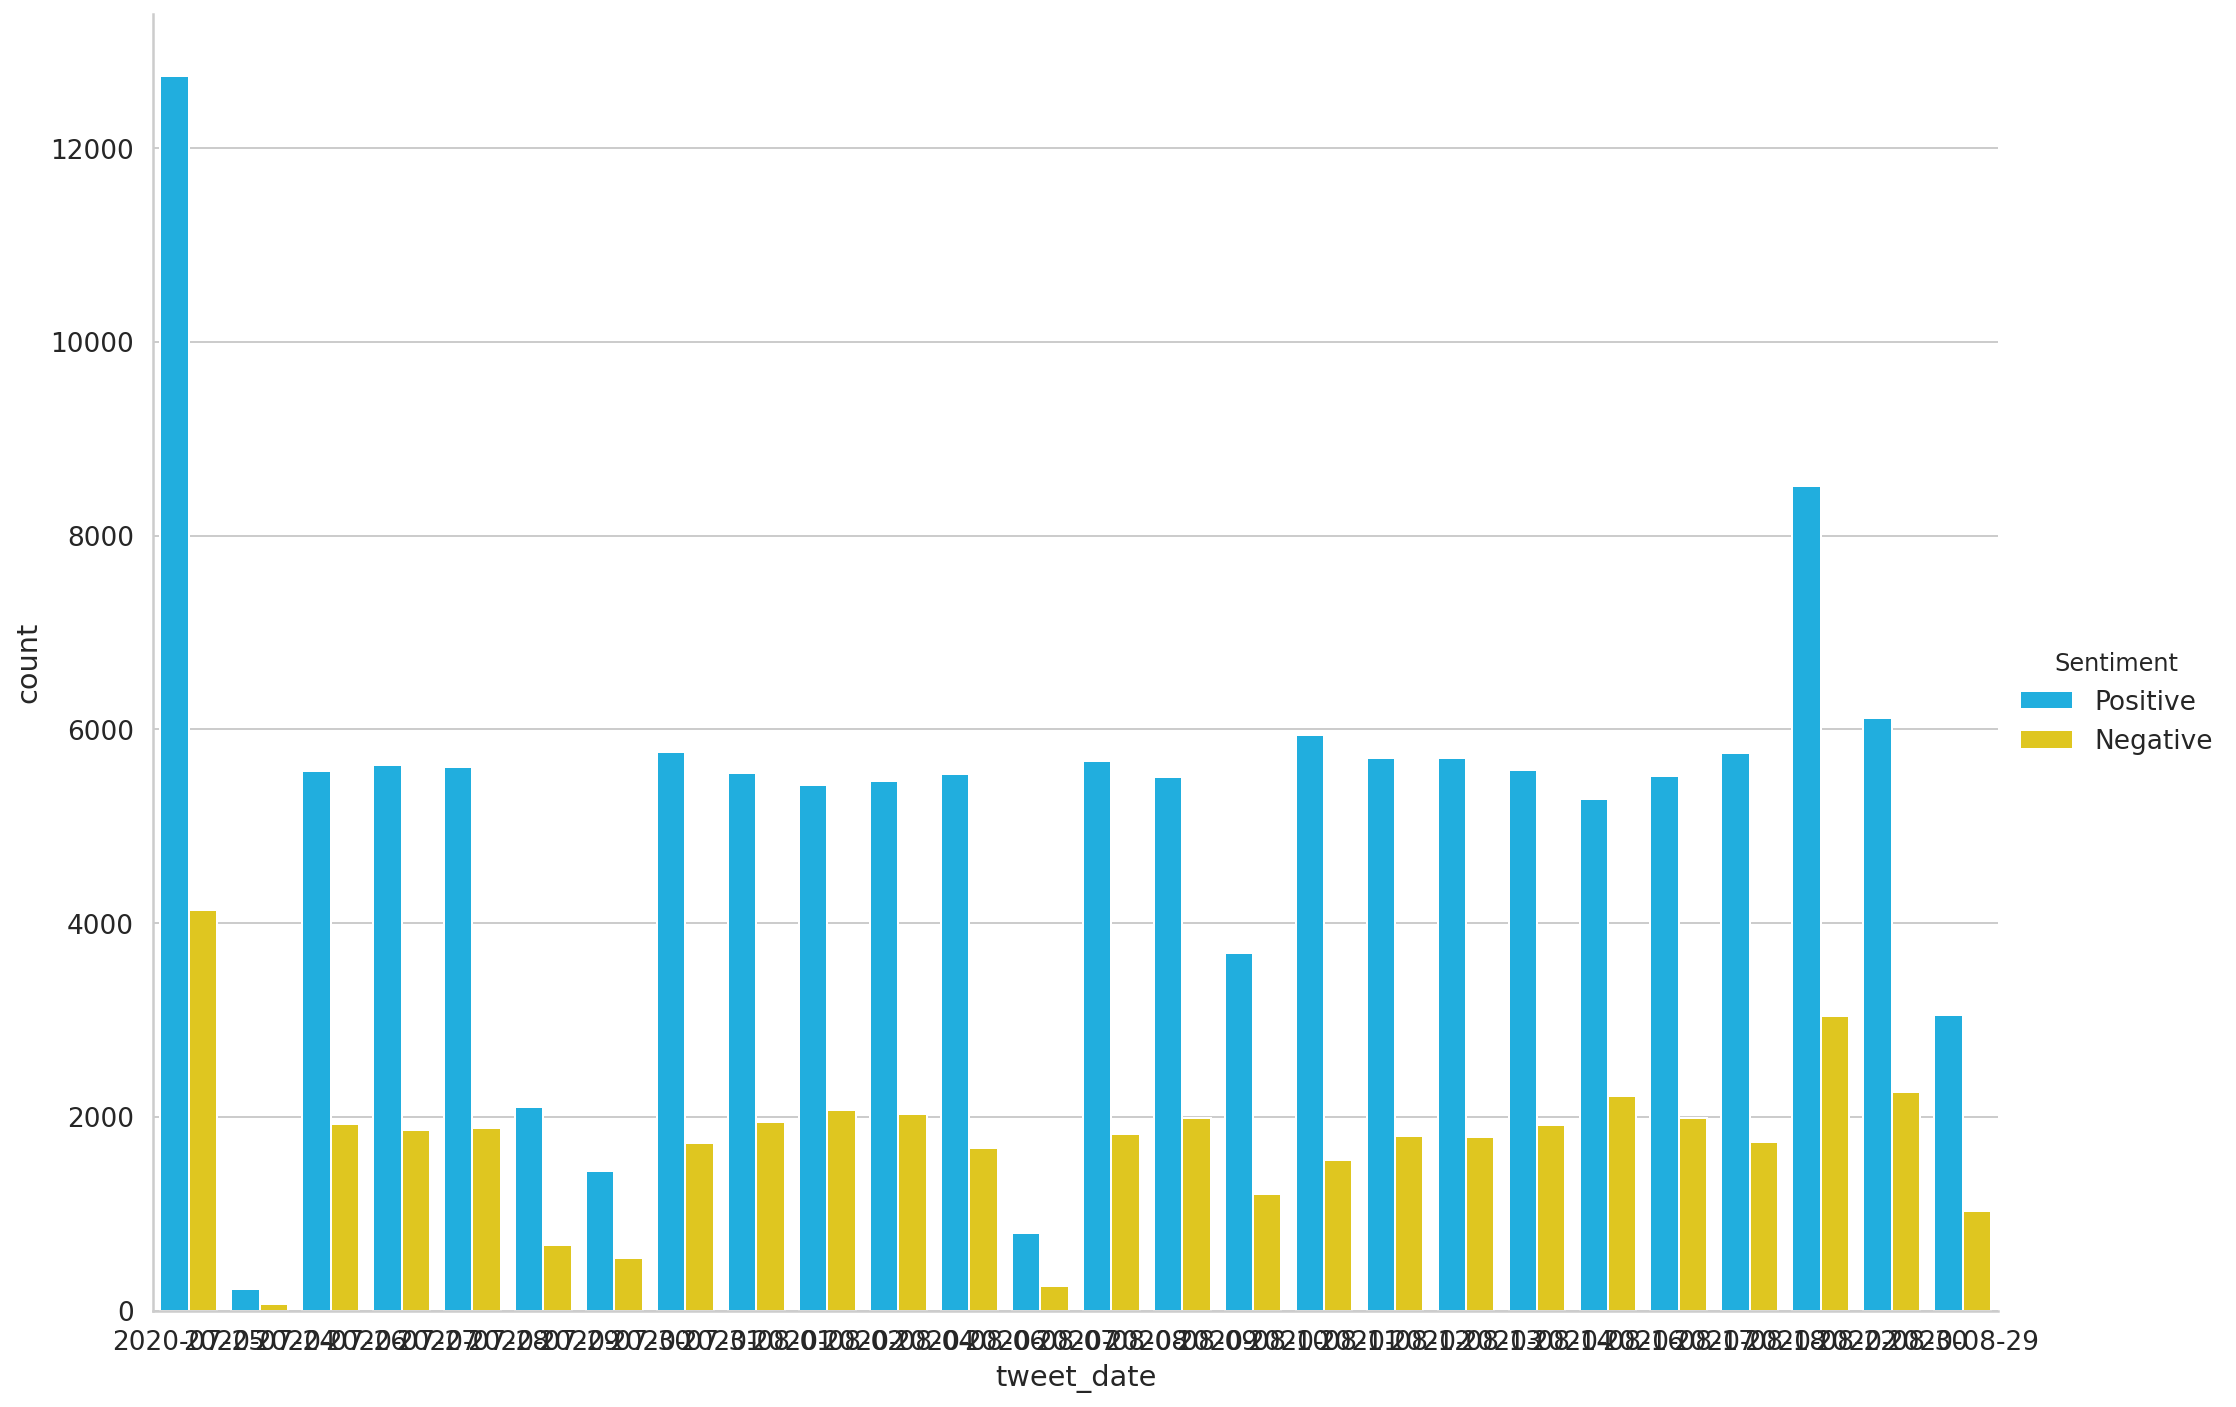

In [ ]:
# Grouping by tweet_date and Sentiment
sns.catplot(data=df, kind='count', x='tweet_date',hue='Sentiment', height=10, aspect=1.4)
# Inference: No of positive tweets on every day were greater than negative tweets by greater than 50% consistently.

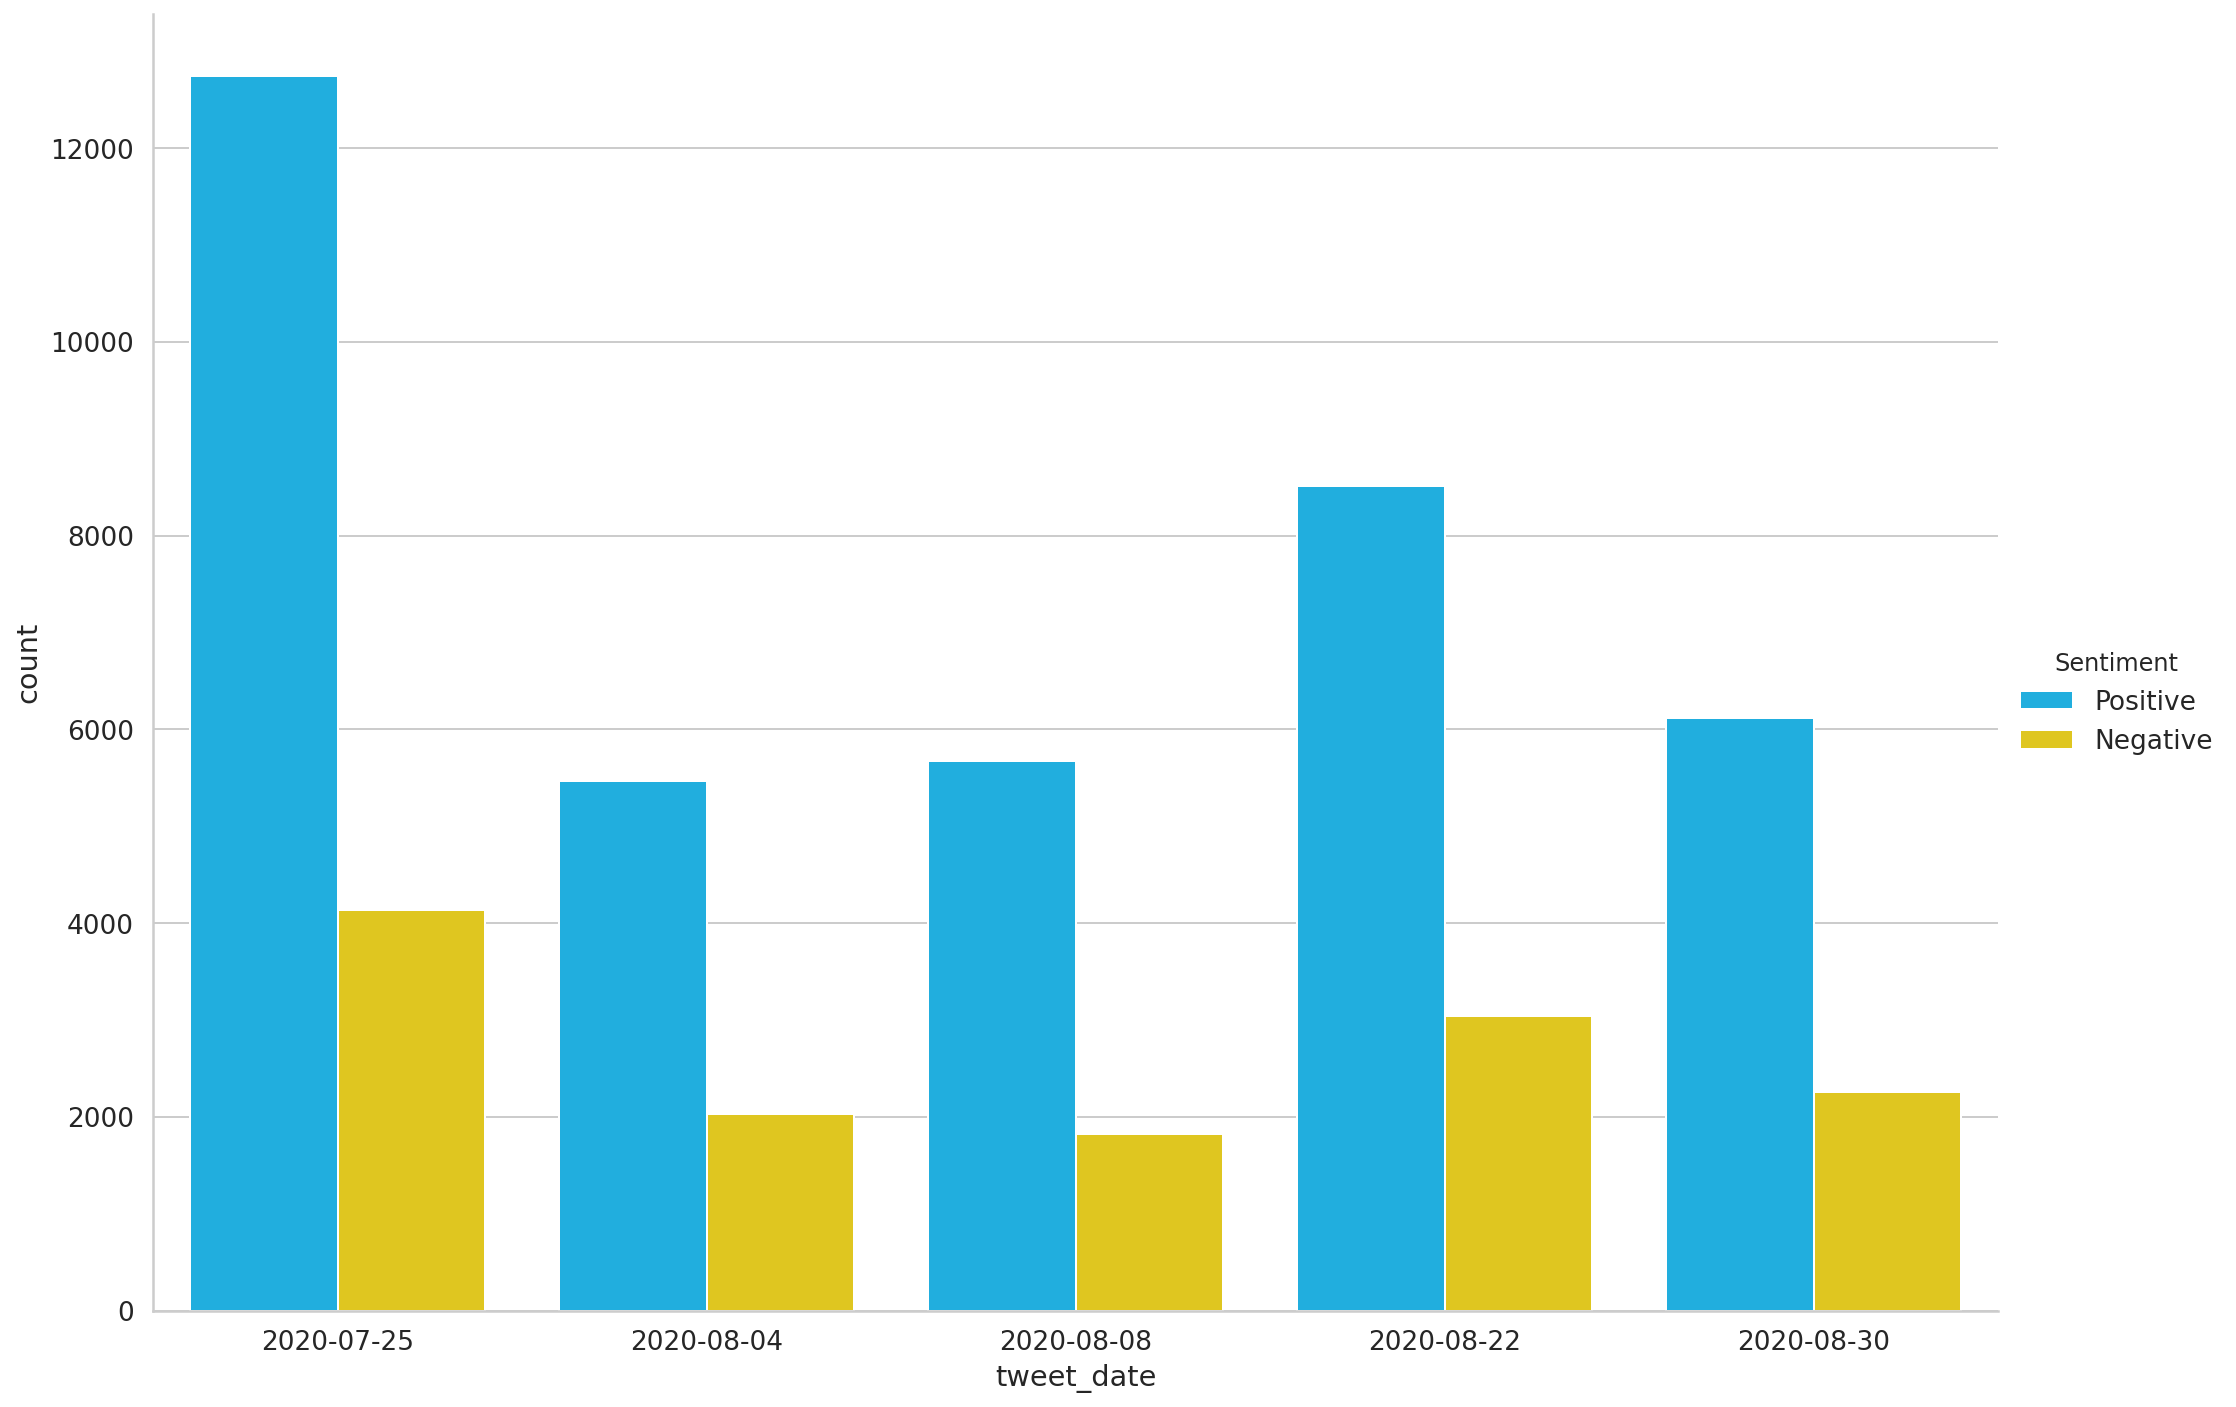

In [ ]:
# Tweet sentiment on top 5 dates with most no of tweets
dates = df['tweet_date'].value_counts()[:5]
df1 = df[df['tweet_date'].isin(dates.index)]

sns.catplot(data=df1, kind='count', x='tweet_date',hue='Sentiment', height=10, aspect=1.4)
# Inference: 2020-07-25 has most no of positive as well as negative tweets

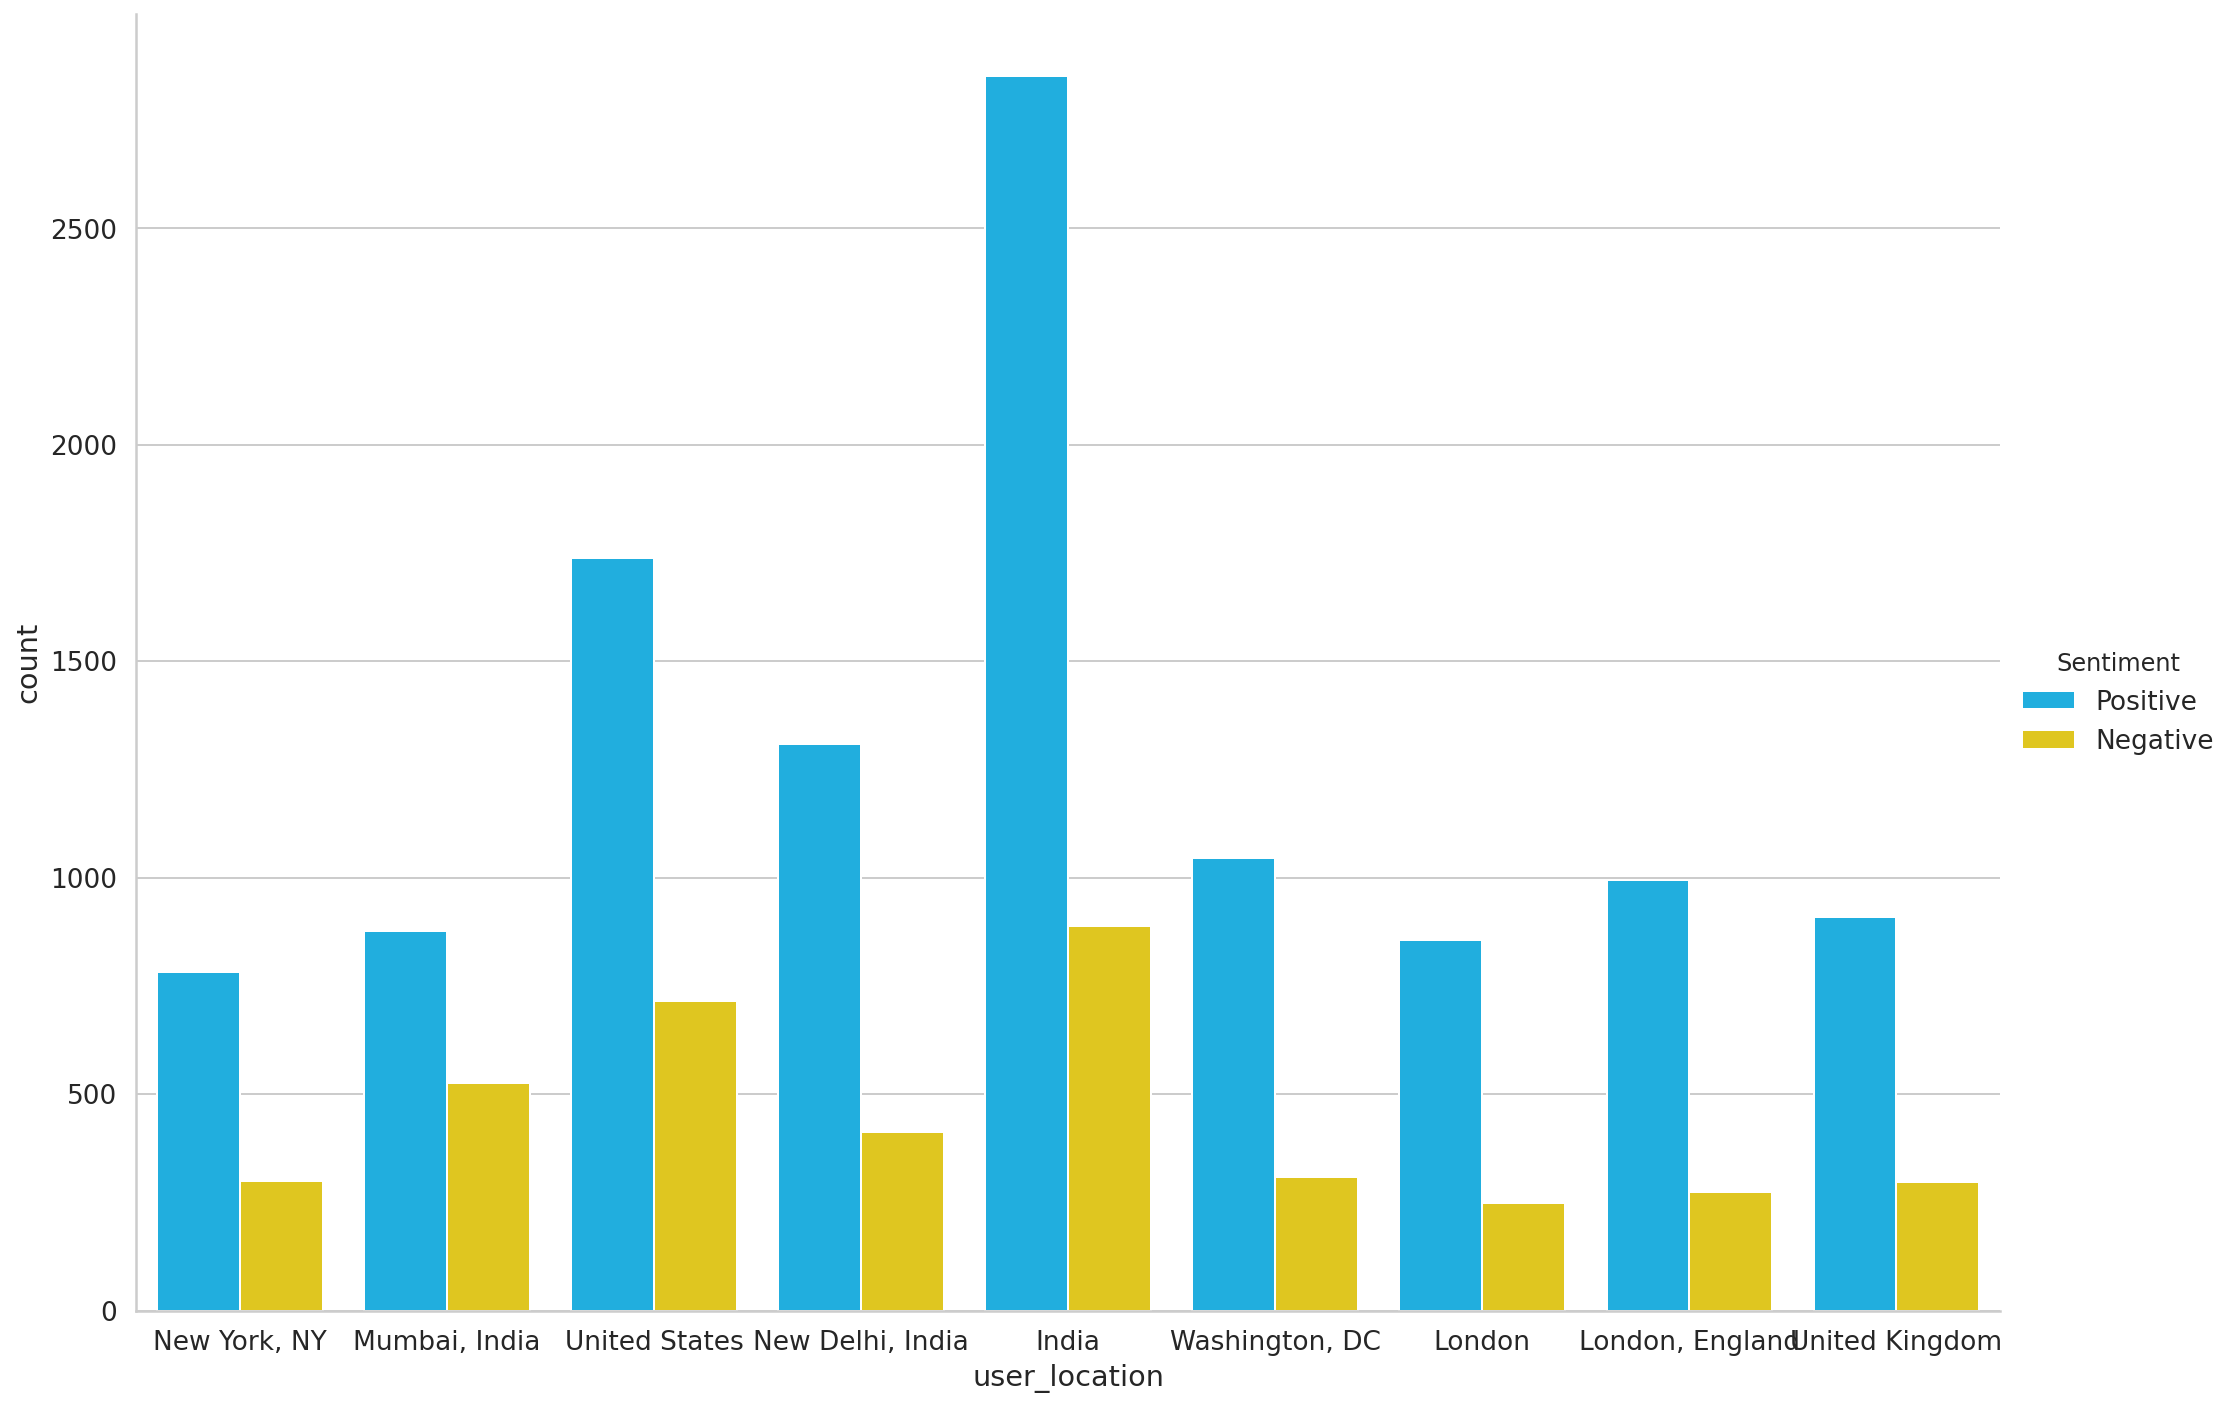

In [ ]:
# Grouping by sentiment and user location
loc = df['user_location'].value_counts()[:10]
loc.drop(labels=['',],inplace=True)
df1 = df[df['user_location'].isin(loc.index)]

sns.catplot(data=df1, kind='count', x='user_location',hue='Sentiment', height=10, aspect=1.4)

# Inference: Among Top 10 locations with most tweets, all locations has positive no of tweets more than 50% of negative number of tweets.

Positive    10671
Negative     3545
Name: Sentiment, dtype: int64


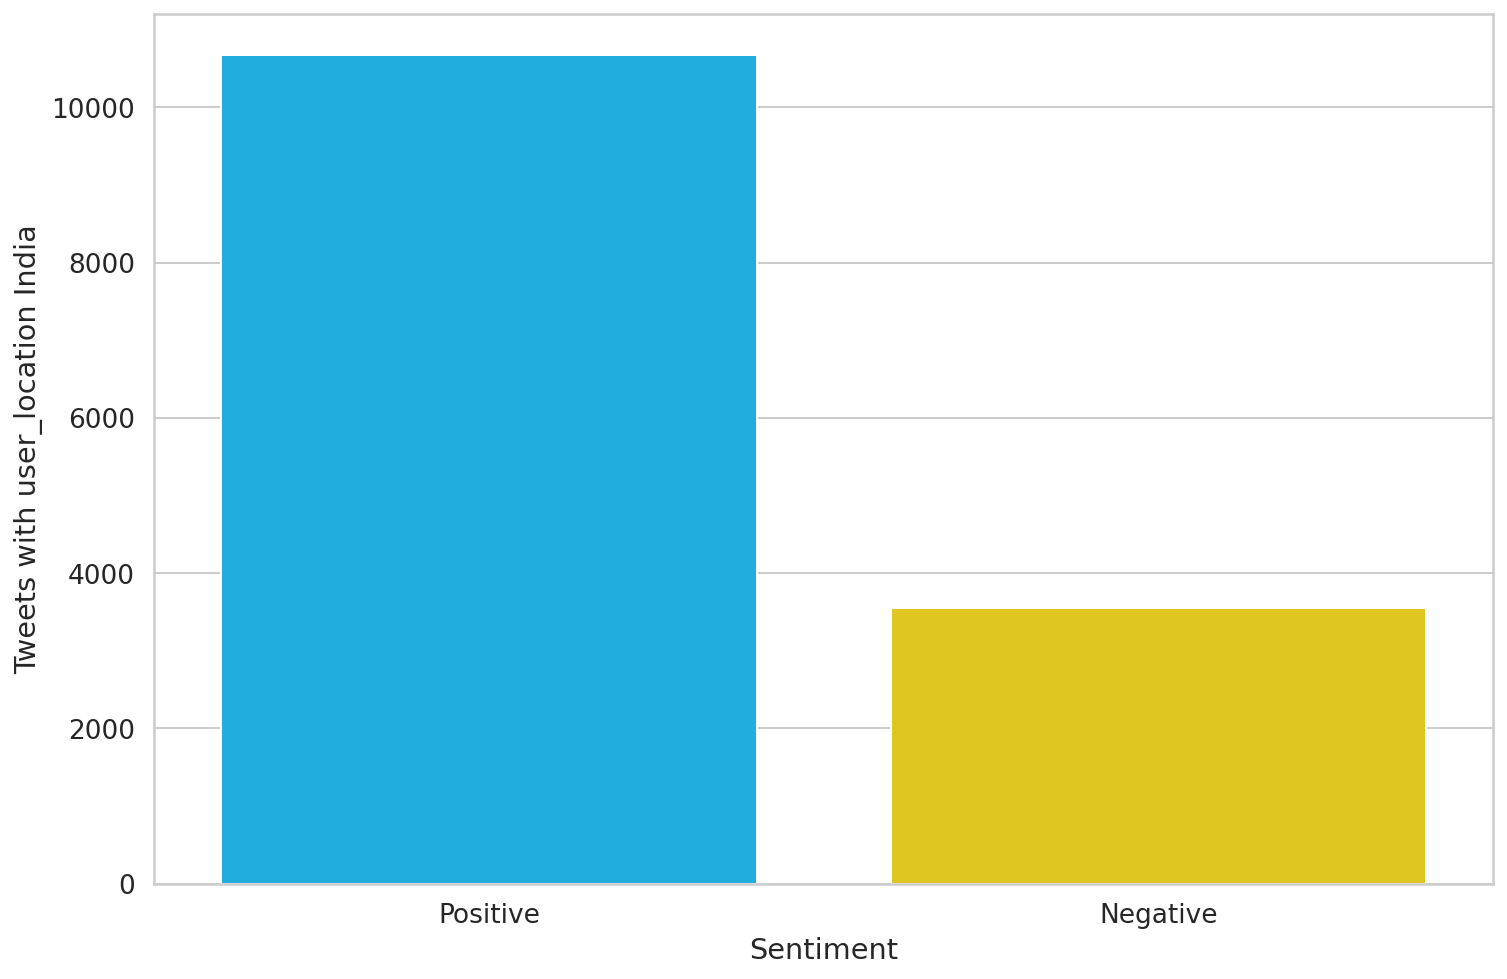

In [ ]:
# Exploring dataframe subset with India in user location
df1 = df[df['user_location'].str.contains('India')]
print(df1['Sentiment'].value_counts())

sns.countplot(df1.Sentiment)
plt.xlabel('Sentiment');
plt.ylabel('Tweets with user_location India');
# Inference: Positive negative tweets ratio with India in user location is slighly increased to 3.01 from overall 2.96

Positive    5877
Negative    2385
Name: Sentiment, dtype: int64


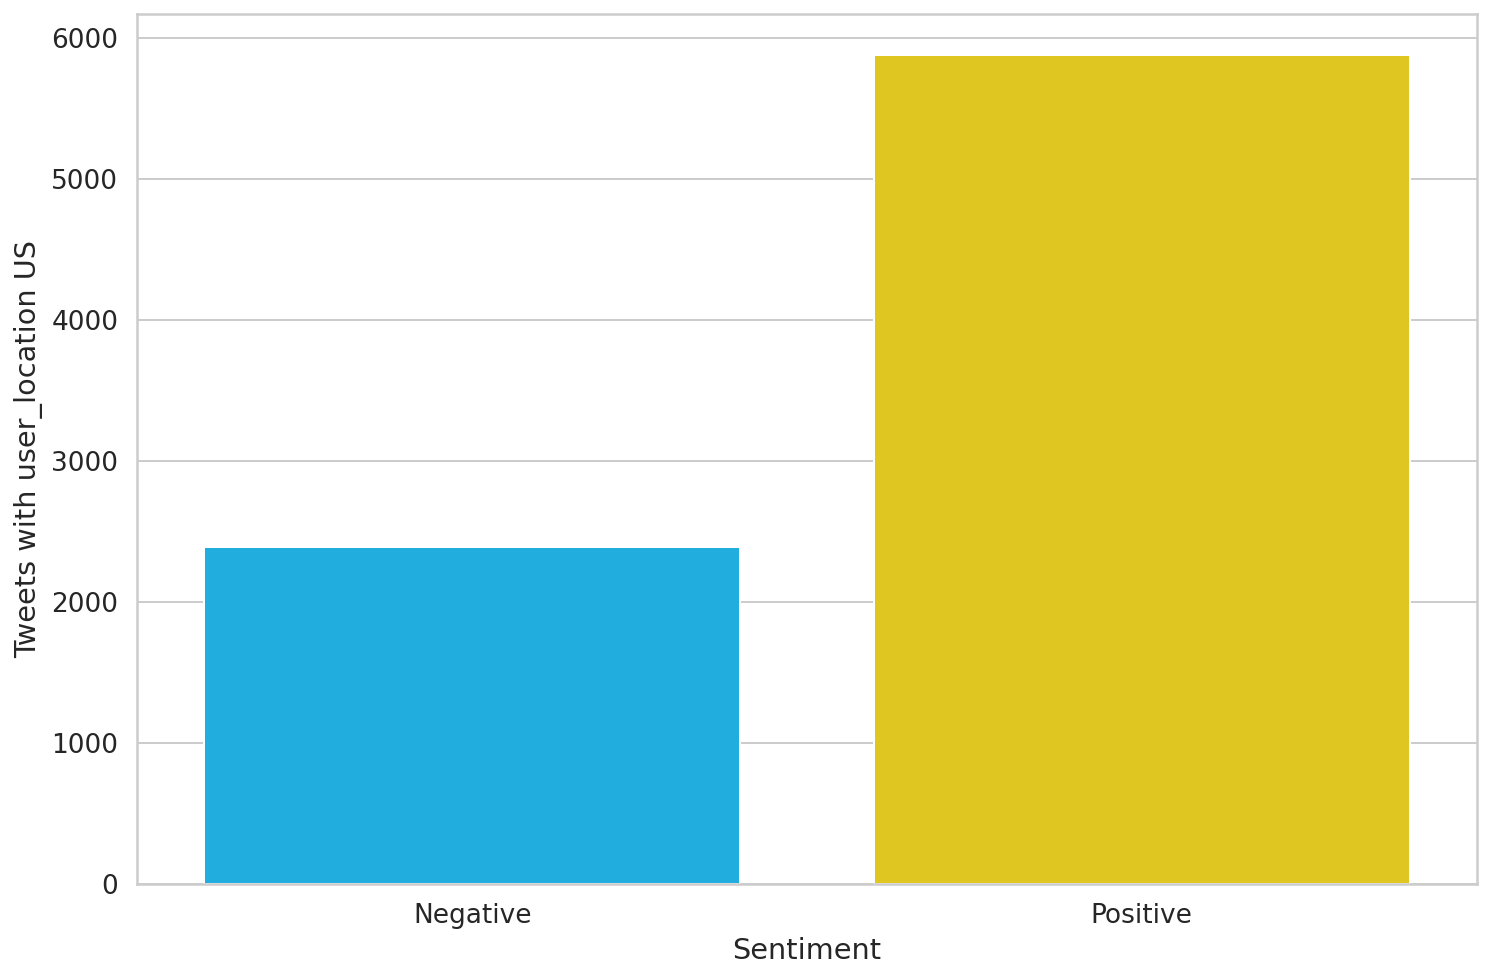

In [ ]:
# Exploring dataframe subset with US in user location
df1 = df[df['user_location'].str.contains('US')]
print(df1['Sentiment'].value_counts())

sns.countplot(df1.Sentiment)
plt.xlabel('Sentiment');
plt.ylabel('Tweets with user_location US');
# Inference: Positive negative tweets ratio with US in user location is drops to 2.46 from overall 2.96

In [ ]:
# Counting most popular hashtags
hash = dict()
for i, row in tqdm(df.iterrows()):
    tag = df.loc[i, 'hashtags']
    if 'str' in str(type(tag)):
        tag = tag.split(',')
        # print(tag)
        for i in range(len(tag)):
            t = tag[i]
            t = re.sub(r'\W+', '', t)
            t = t.lower()
            t.strip()
            if t not in hash:
                hash[t] = 1
            else:
                hash[t] += 1
    else:
        # Replacing nan values with empty string
        null+=1
        df.at[i, 'hashtags'] = ''
print(len(hash))      


37688


In [ ]:
# Checking null values in hashtags
df['hashtags'].isnull().sum()

0

In [ ]:
# Getting Top10 hashtags
top10 = sorted(hash, key=hash.get, reverse=True)[:11]
top10.remove('')
val = []
for i in top10:
    val.append(hash[i])

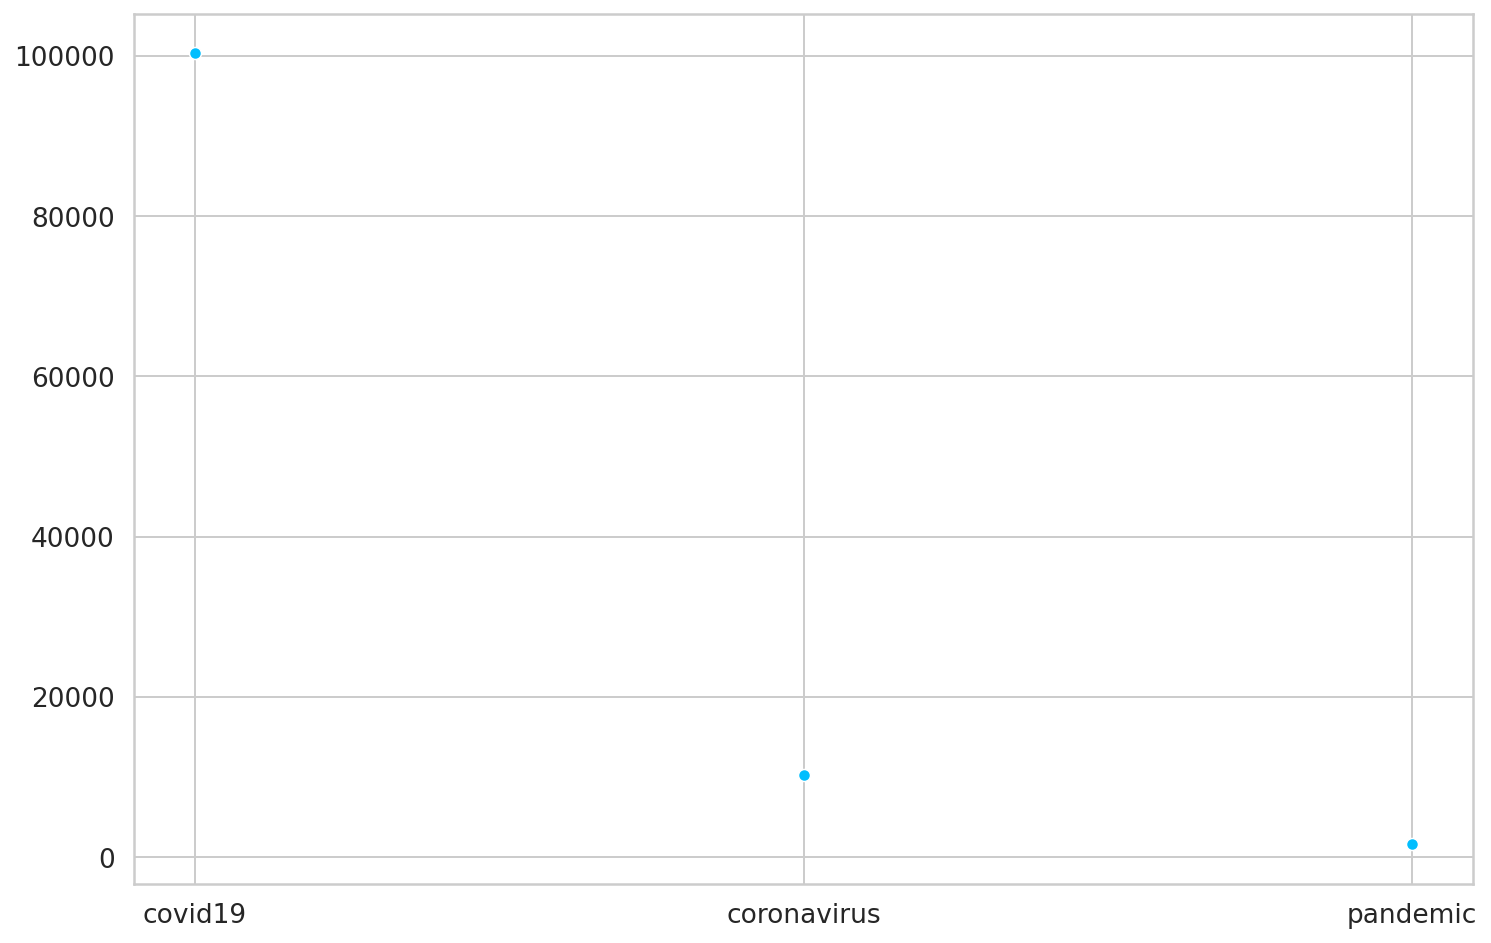

In [ ]:
# Plot of most tags
sns.scatterplot(x=top10[:3], y=val[:3])
# Inference: covid19, coronavirus were among the most popular hashtags used

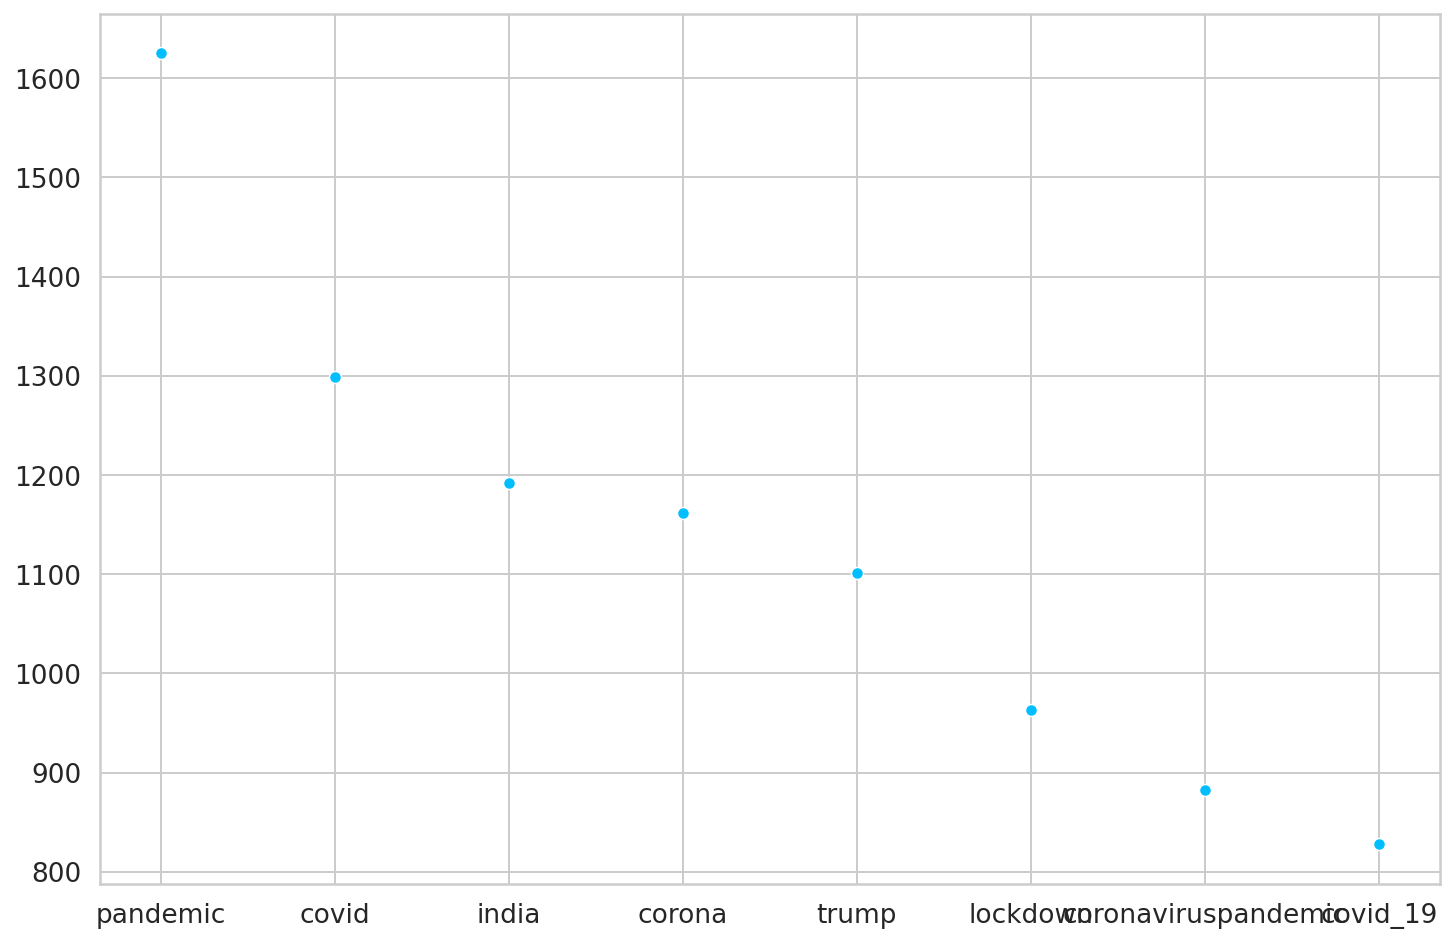

In [ ]:
# Plot of most tags
sns.scatterplot(x=top10[2:], y=val[2:])
# Inference: Trump was the most popular hashtags used among persons.

Positive    273
Negative    100
Name: Sentiment, dtype: int64


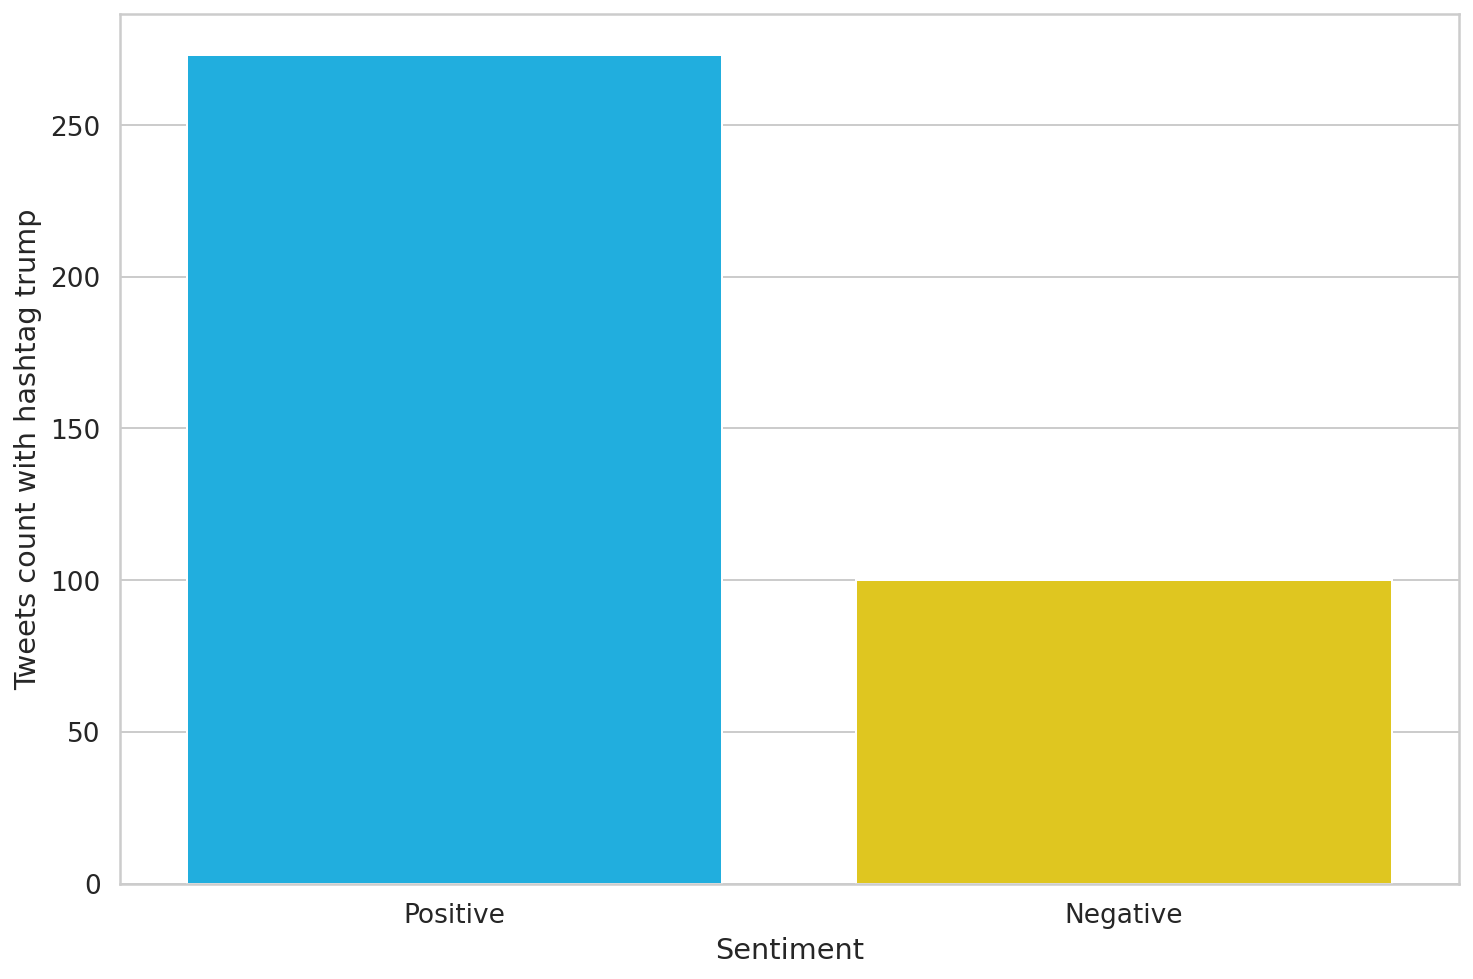

In [ ]:
# Exploring dataframe subset with trump as one of hashtag
df1 = df[df['hashtags'].str.contains('trump')]
print(df1['Sentiment'].value_counts())

sns.countplot(df1.Sentiment)
plt.xlabel('Sentiment');
plt.ylabel('Tweets count with hashtag trump');

# Inference: The negative-positive tweet ratio is slightly dropped to 2.73 from overall 2.965 in tweets that involved trump as hashtag

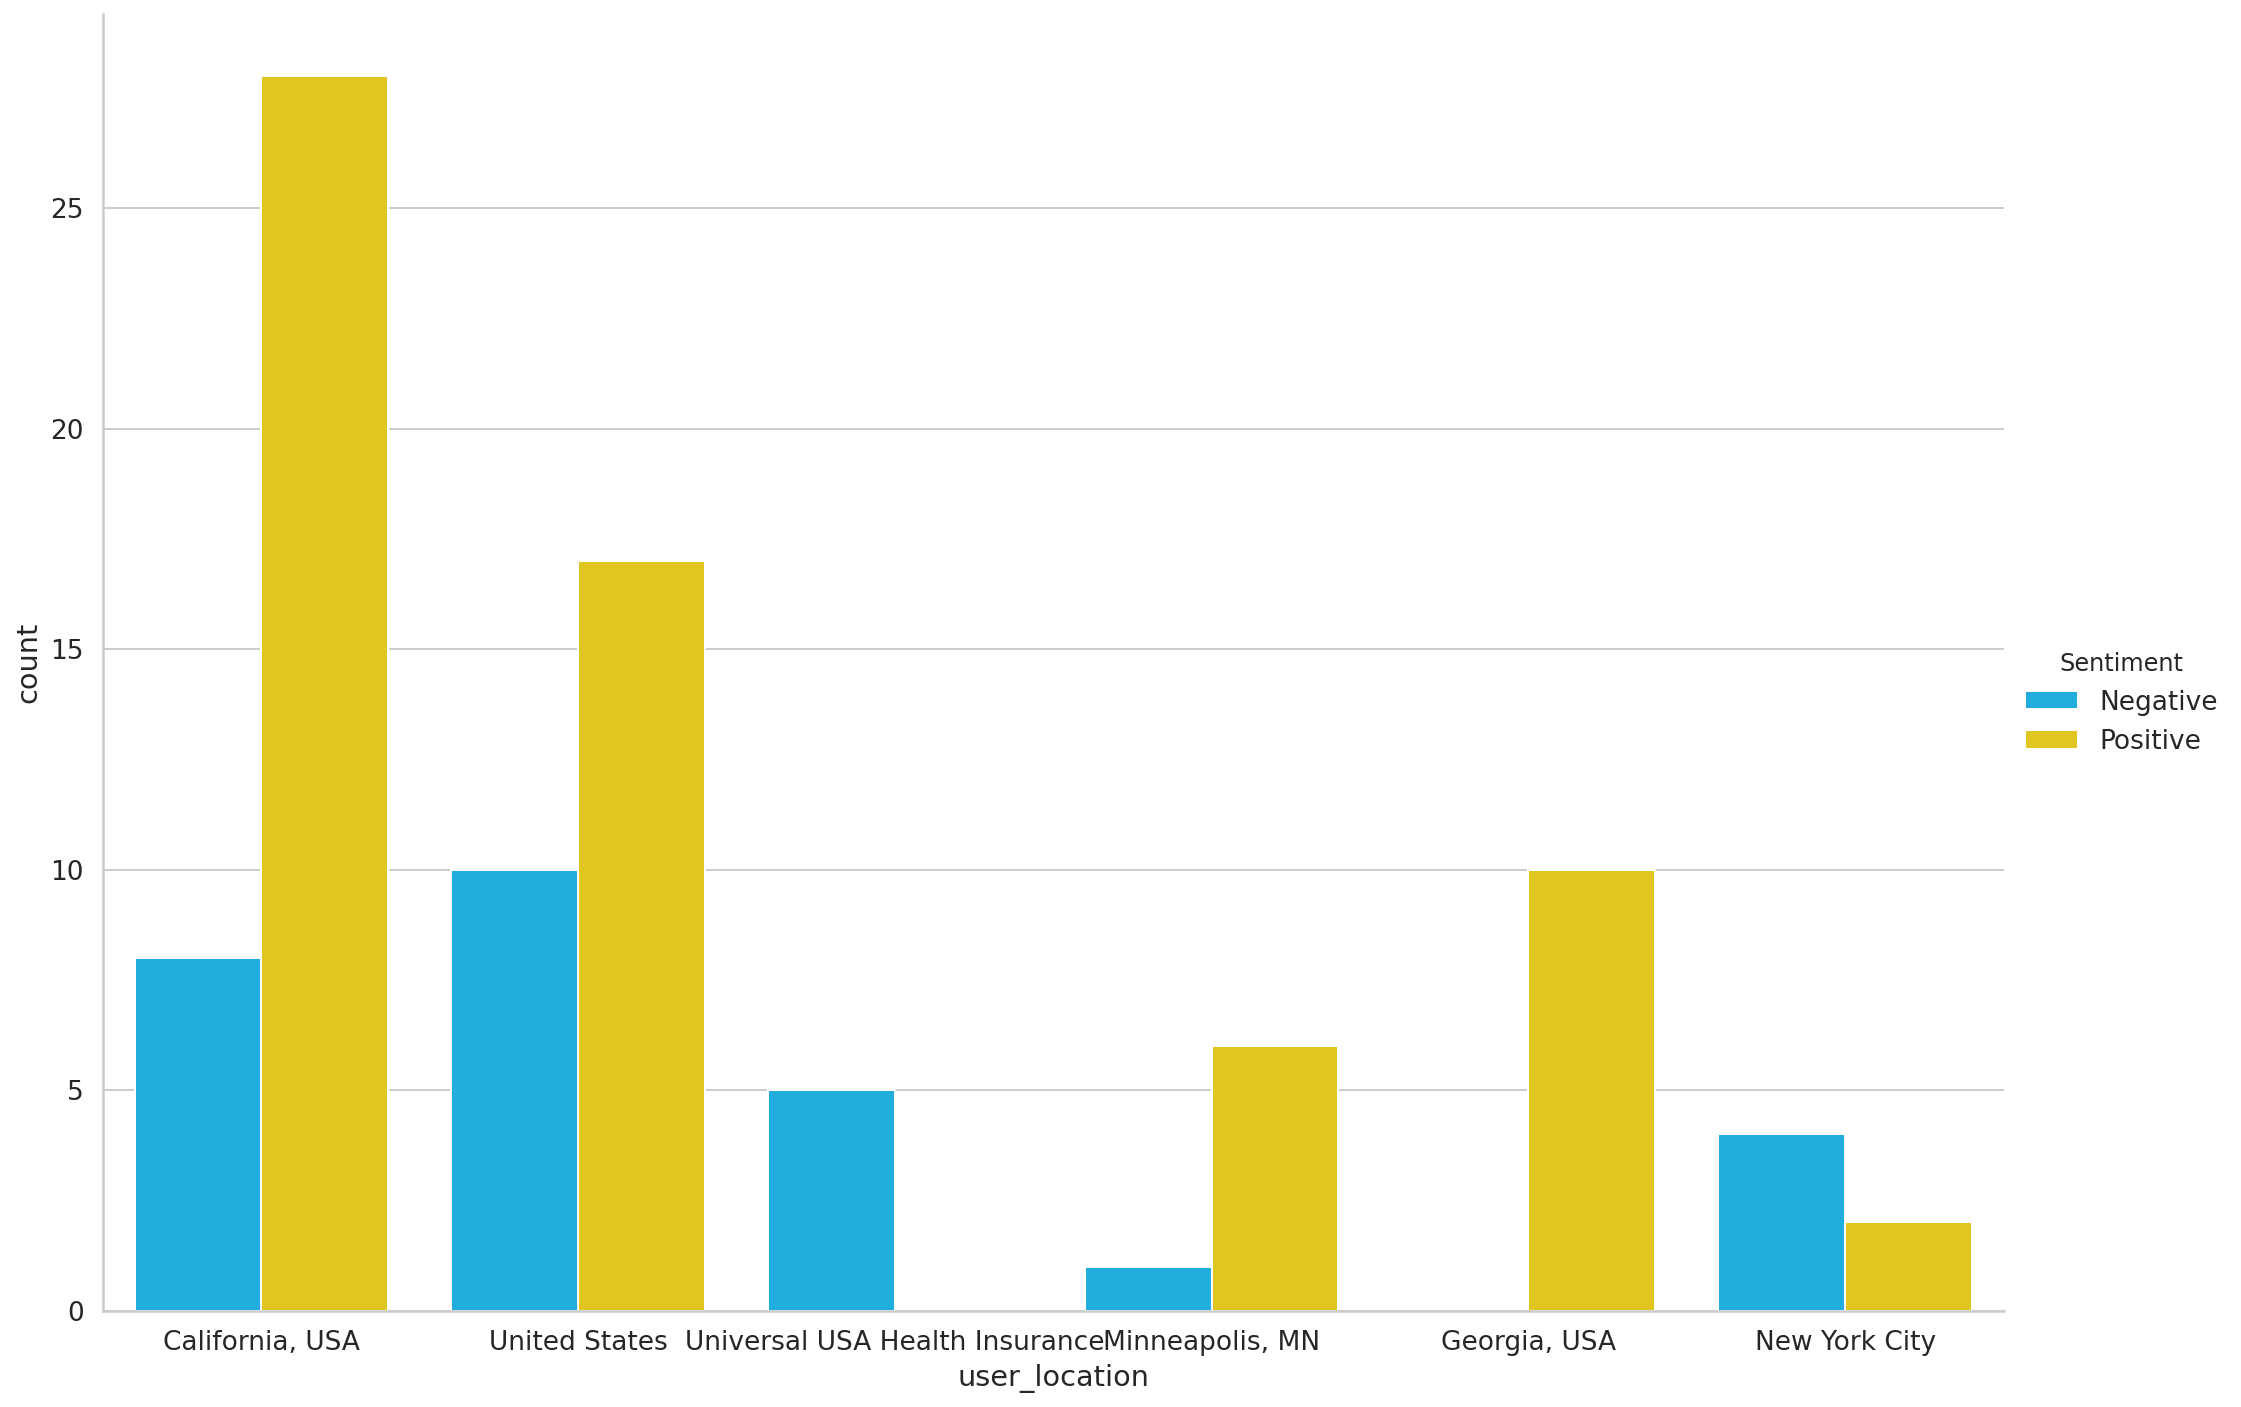

In [ ]:
# Exploring sentiments of top 6 locations with tweets involving trump as hashtag
loc = df1['user_location'].value_counts()
loc = loc[loc>=5]
loc.drop(labels=['',],inplace=True)
df2 = df1[df1['user_location'].isin(loc.index)]
sns.catplot(data=df2, kind='count', x='user_location',hue='Sentiment', height=10, aspect=1.4)
# Inference: Trump hashtag was much used in US and has more positive tweets involoved.

Positive    234
Negative     49
Name: Sentiment, dtype: int64


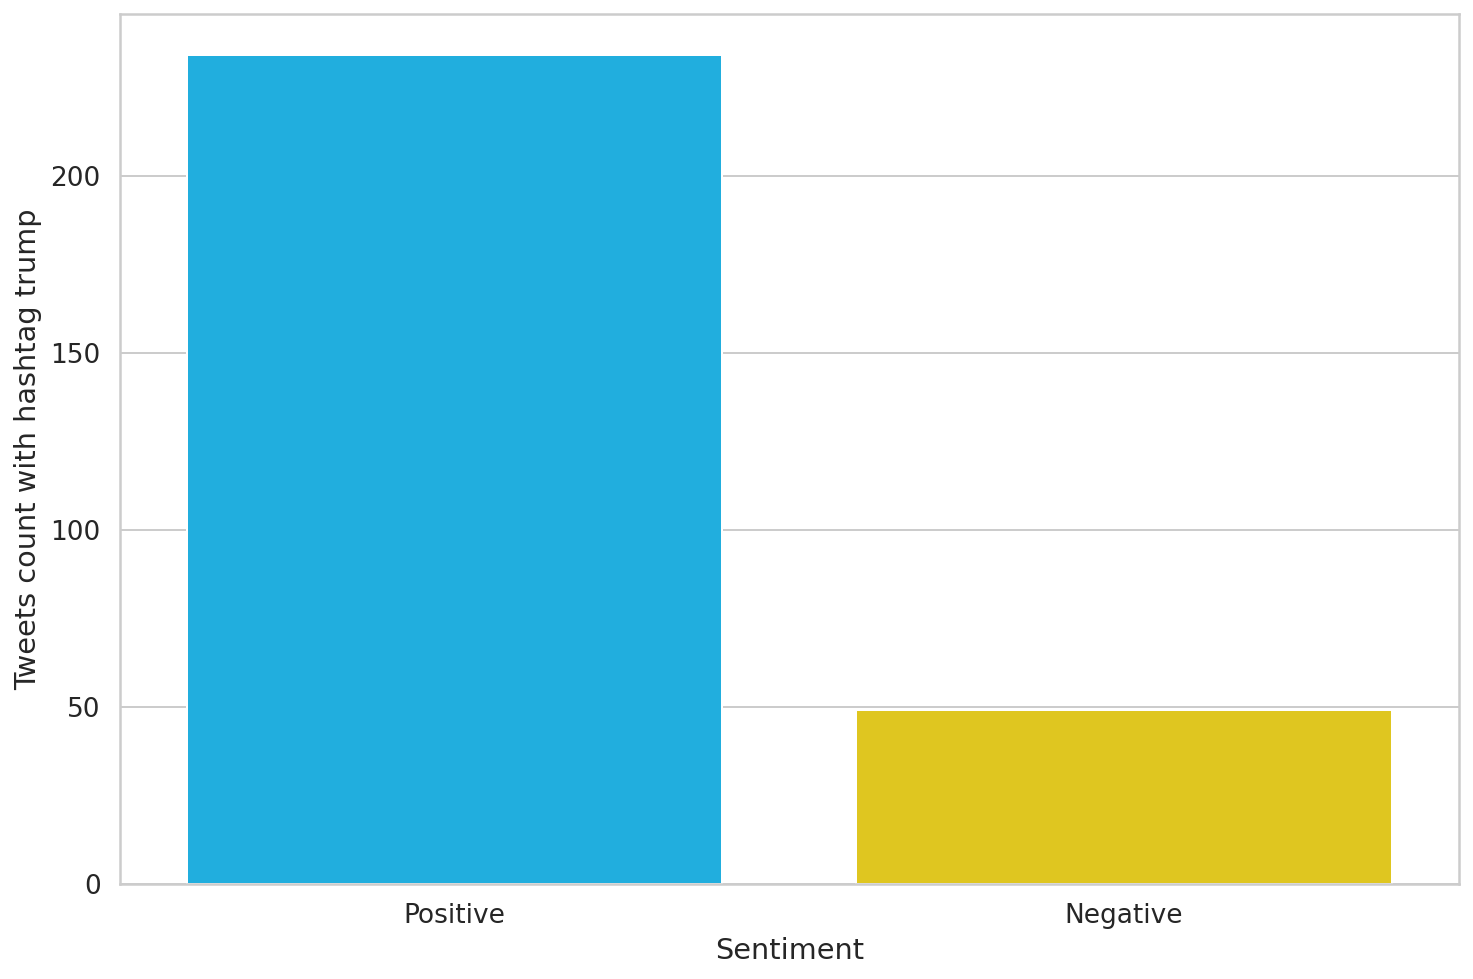

In [ ]:
# Exploring dataframe subset with india as one of hashtag
df1 = df[df['hashtags'].str.contains('india')]
print(df1['Sentiment'].value_counts())

sns.countplot(df1.Sentiment)
plt.xlabel('Sentiment');
plt.ylabel('Tweets count with hashtag trump');

# Inference: The negative-positive tweet ratio is remarkably increased to 4.77 from overall 2.97

In [ ]:
# Exploring dataframe with user_followers > 1 million
df1 = df.loc[:,['user_followers', 'Sentiment']]
df2 = df1[df1['user_followers']>1000000]
print(df2['Sentiment'].value_counts())


# Exploring dataframe with user_followers < 1000
df1 = df.loc[:,['user_followers', 'Sentiment']]
df2 = df1[df1['user_followers']<1000]
print(df2['Sentiment'].value_counts())

Positive    2451
Negative     982
Name: Sentiment, dtype: int64
Positive    66732
Negative    22967
Name: Sentiment, dtype: int64


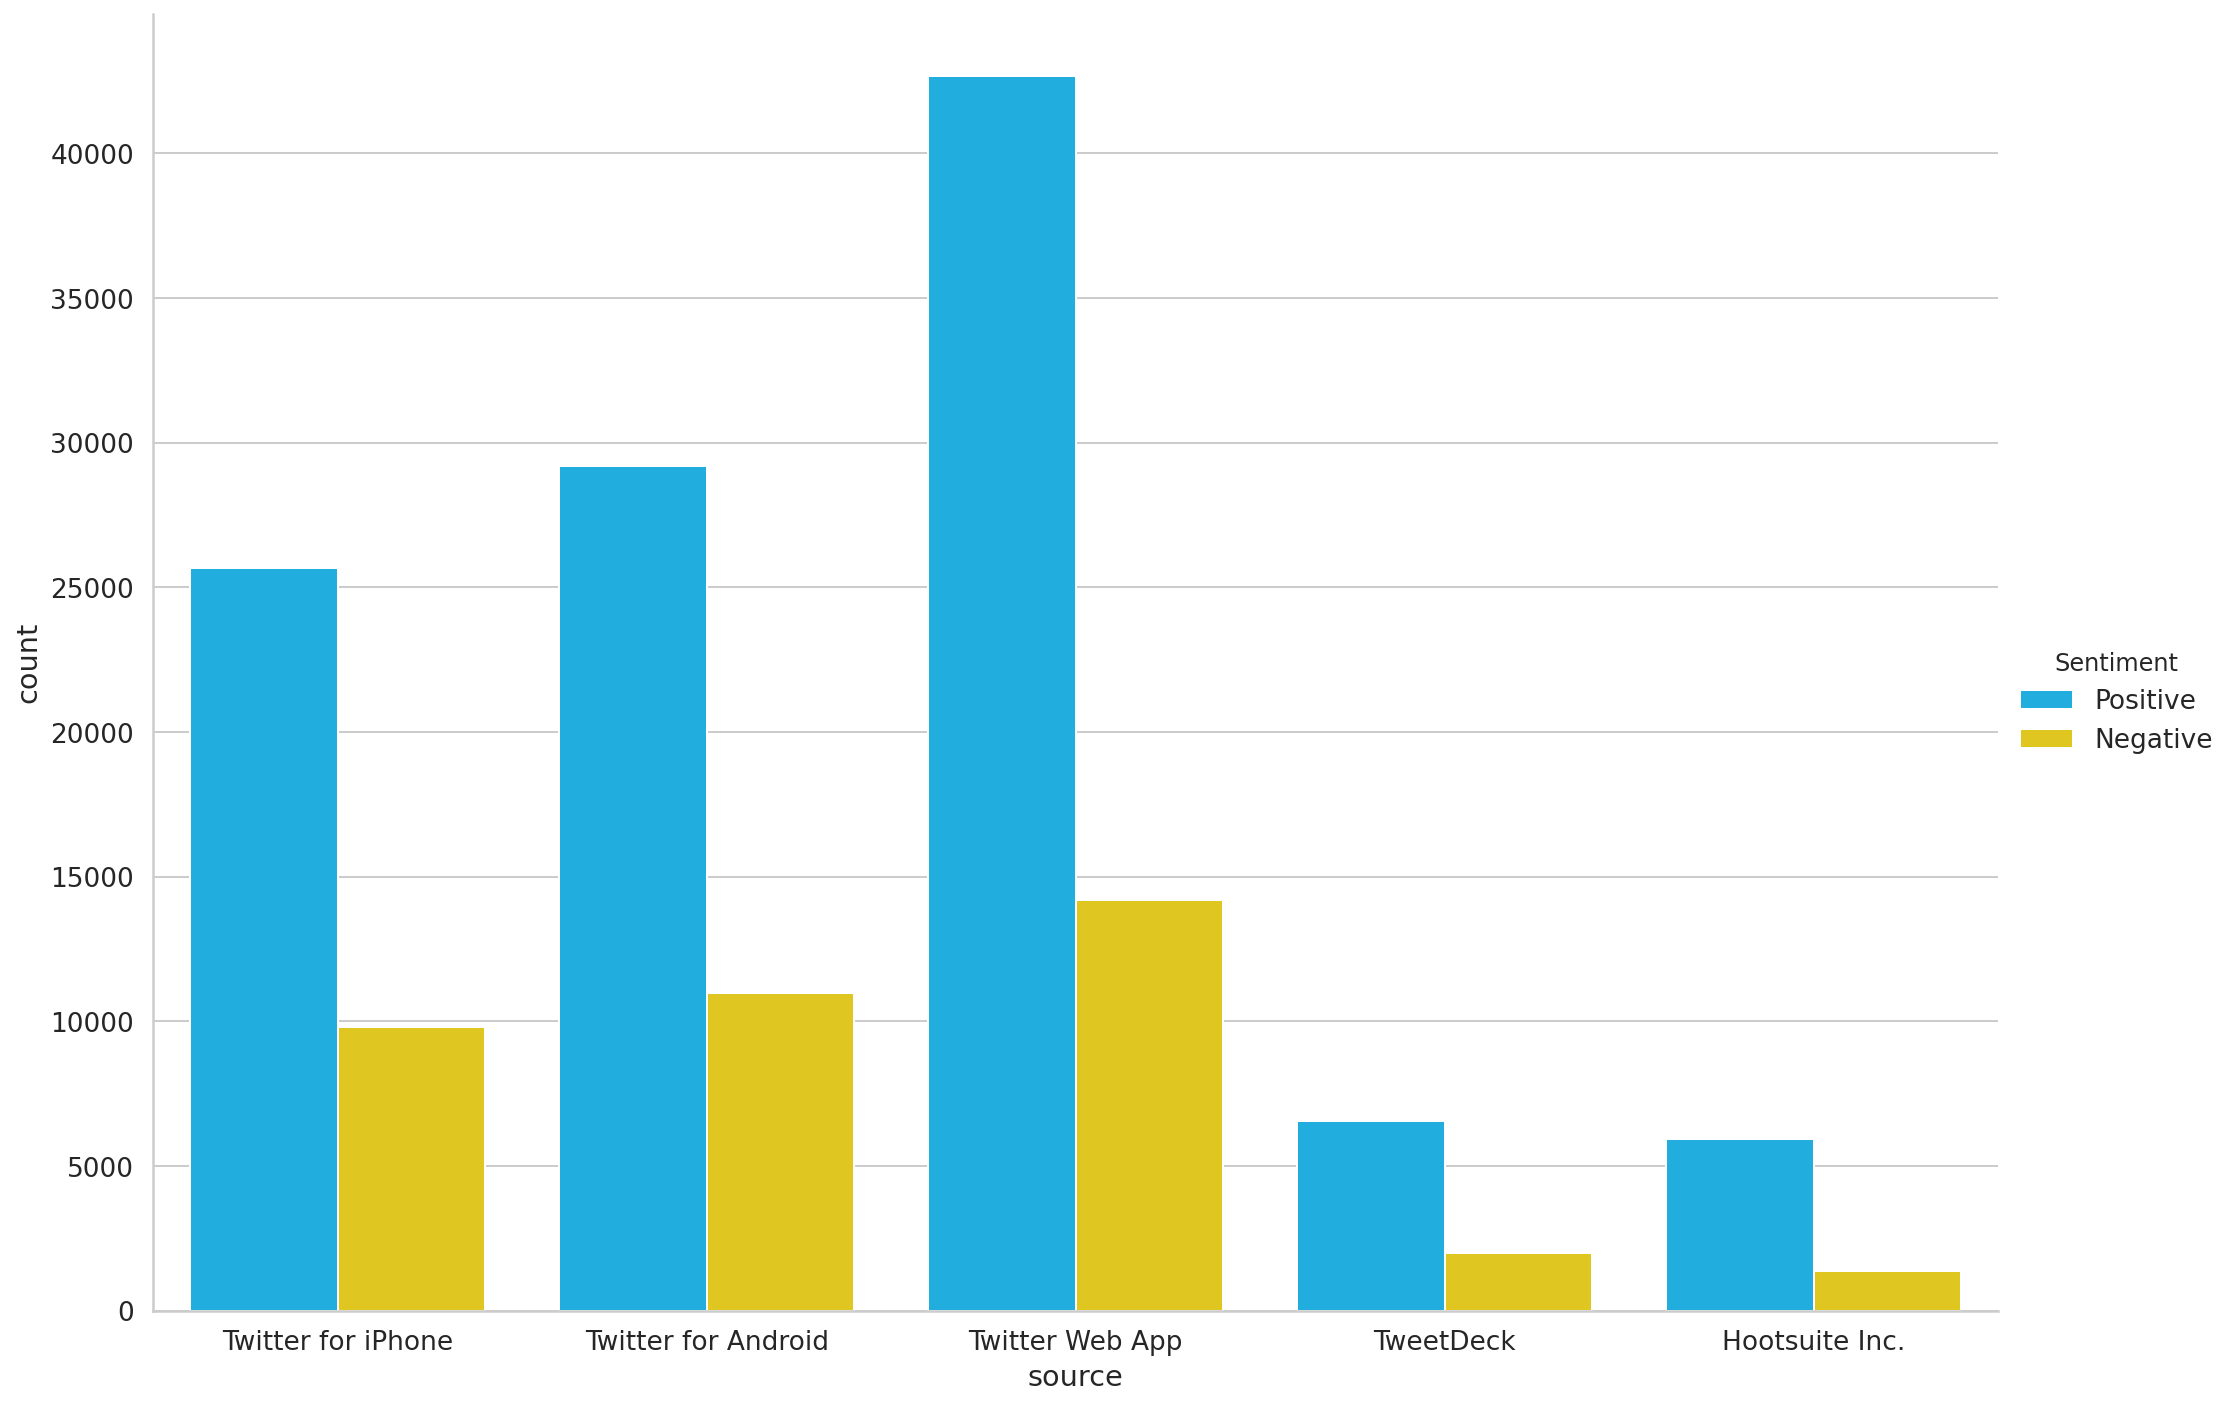

In [ ]:
# Comparing sentiment and tweet source
source = df['source'].value_counts()[:5]
df1 = df[df['source'].isin(source.index)]
sns.catplot(data=df1, kind='count', x='source',hue='Sentiment', height=10, aspect=1.4)
# Inference: The positive negative ratio in tweets from sources is similar to overall average

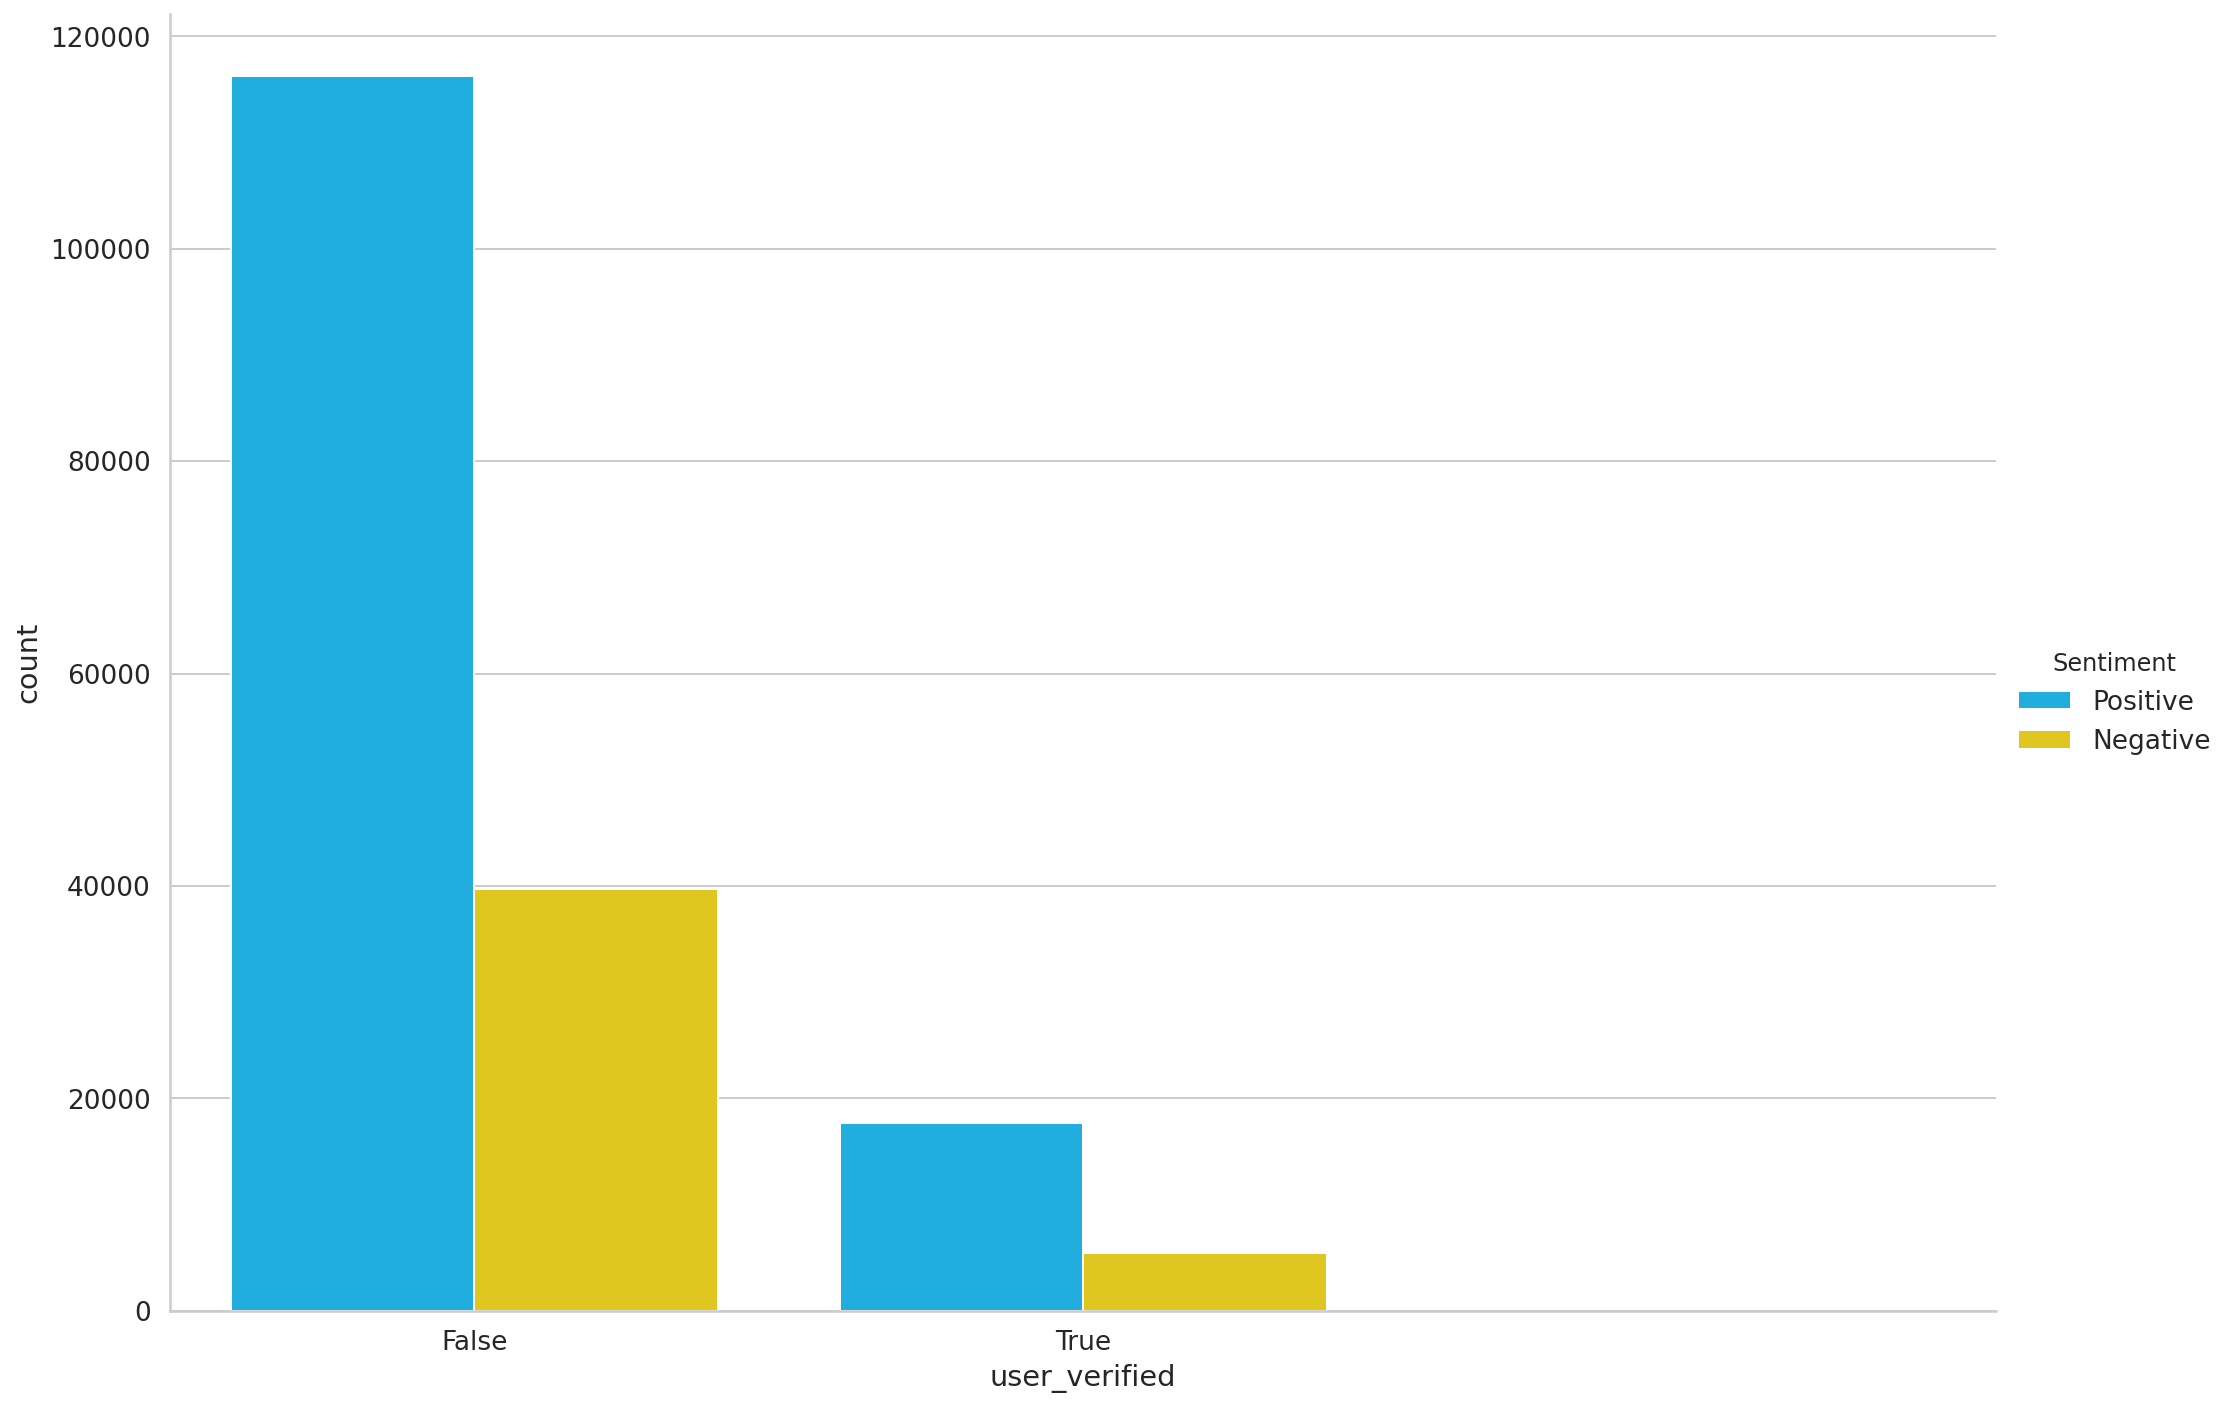

In [ ]:
# Analyzing sentiments with verification status of twitter
user = df['user_verified'].value_counts()
df1 = df[df['user_verified'].isin(user.index)]
sns.catplot(data=df1, kind='count', x='user_verified',hue='Sentiment', height=10, aspect=1.4)
# Inference: The Positive to negative twet ratio is similar among verified and non verified users.

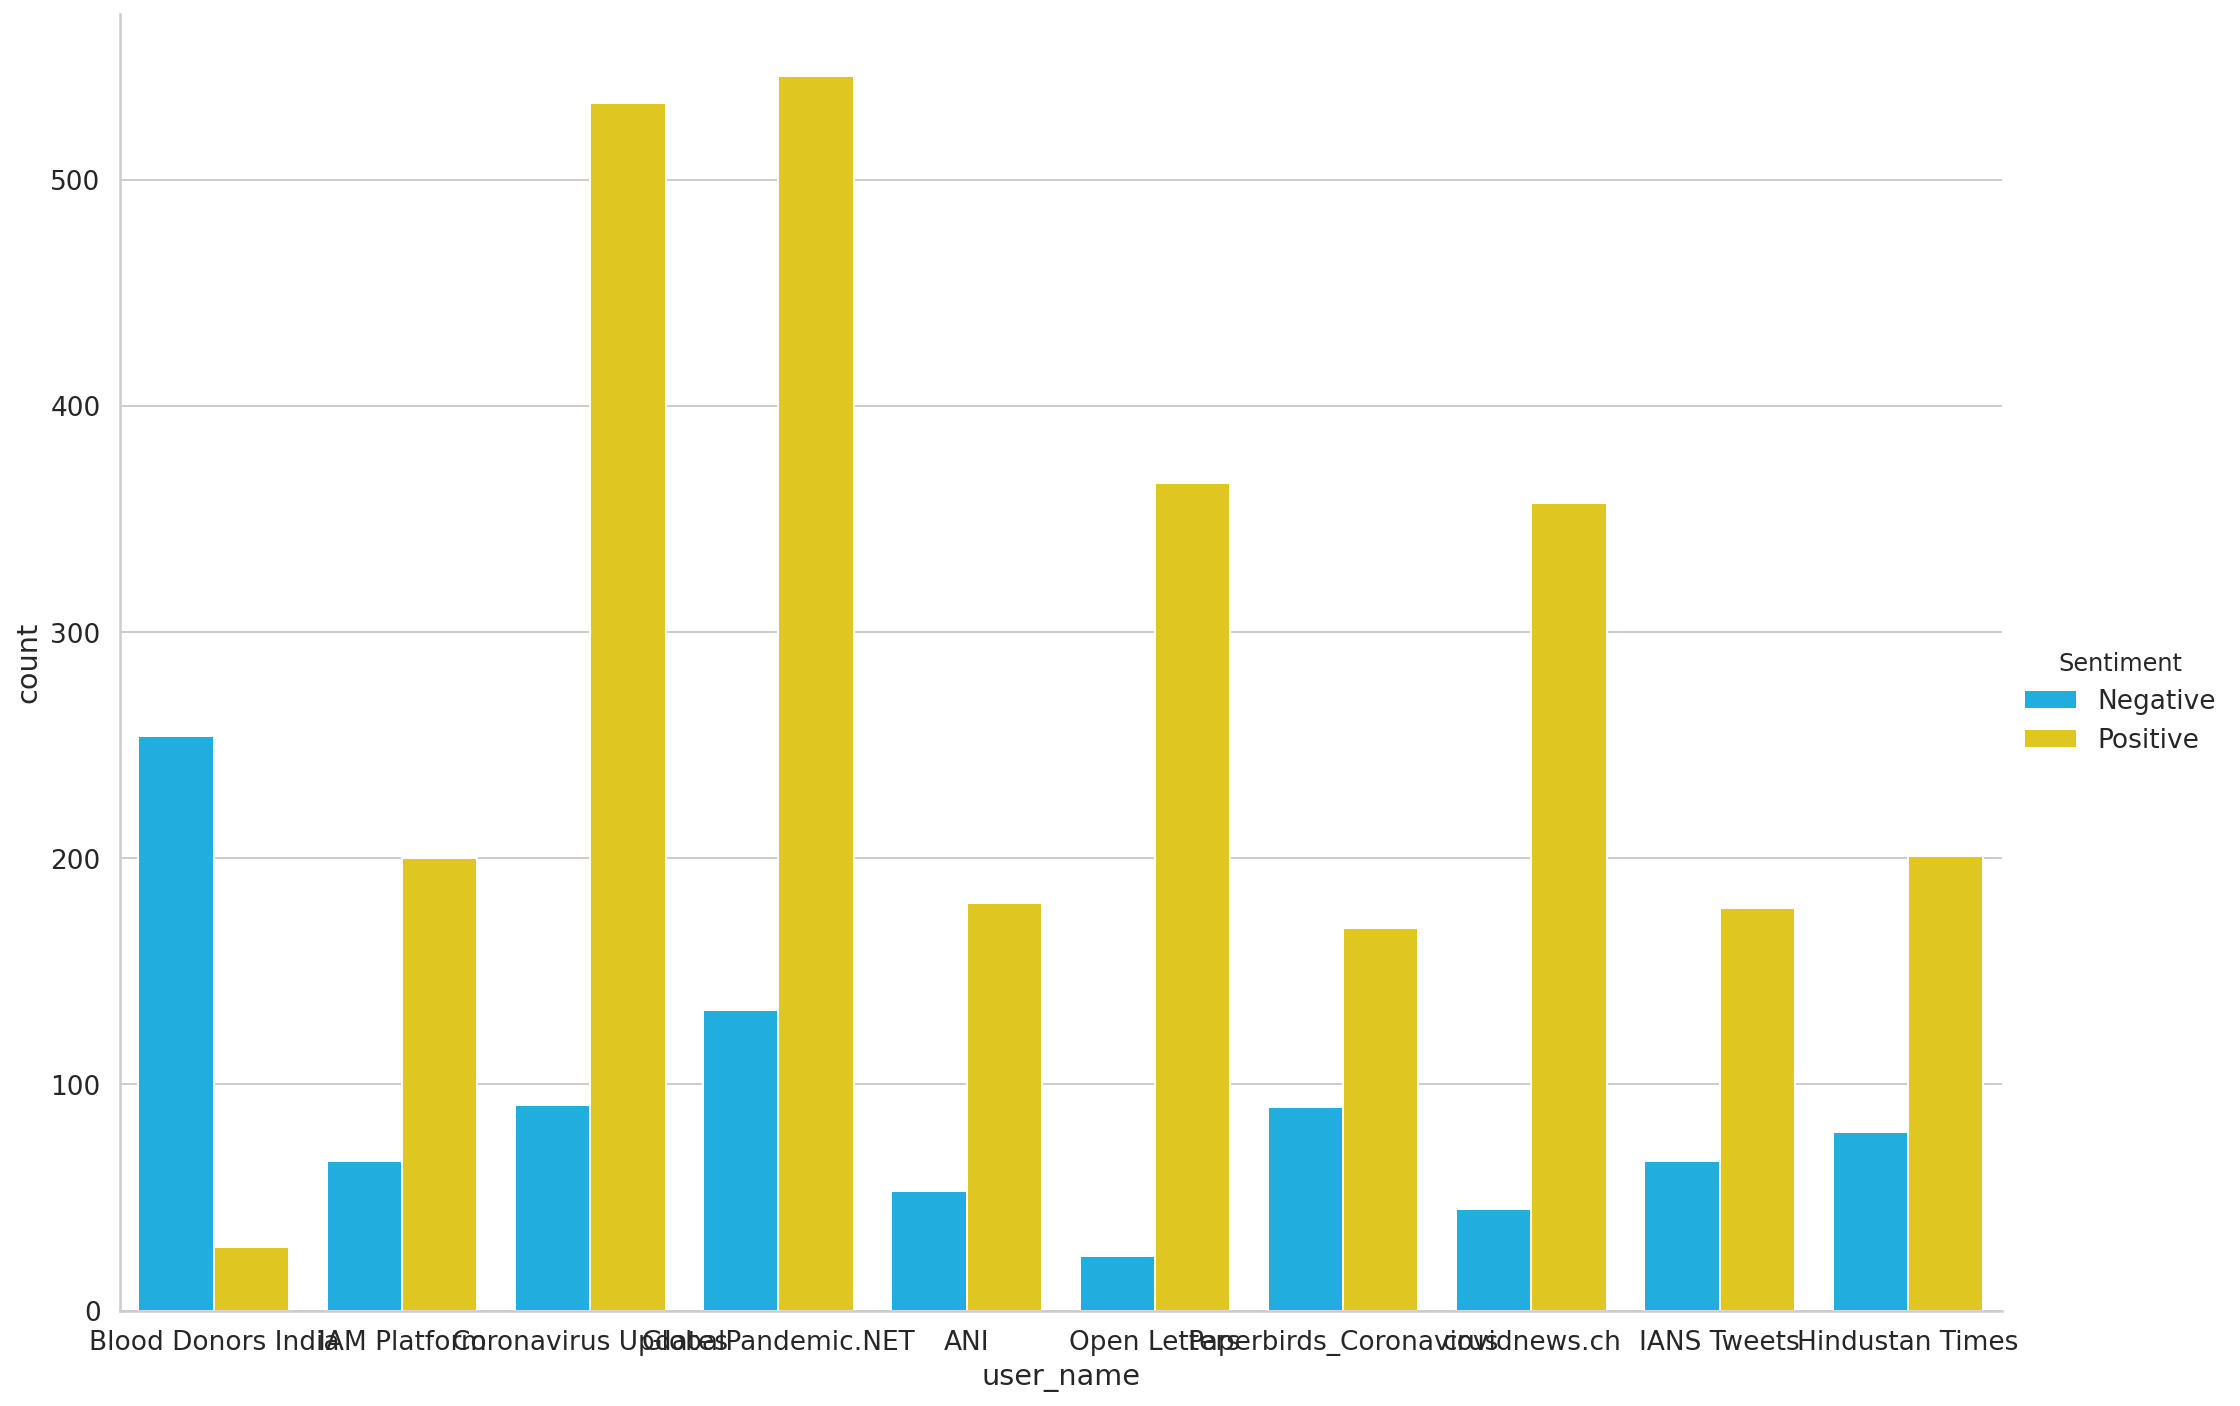

In [ ]:
# Analyzing sentiments of top10 users with most tweets
user = df['user_name'].value_counts()[:10]
df1 = df[df['user_name'].isin(user.index)]
sns.catplot(data=df1, kind='count', x='user_name',hue='Sentiment', height=10, aspect=1.4)
# Inference: Among top10 users with most tweets user_name Blood Donors has remarkably high ratio of negative to positive tweets

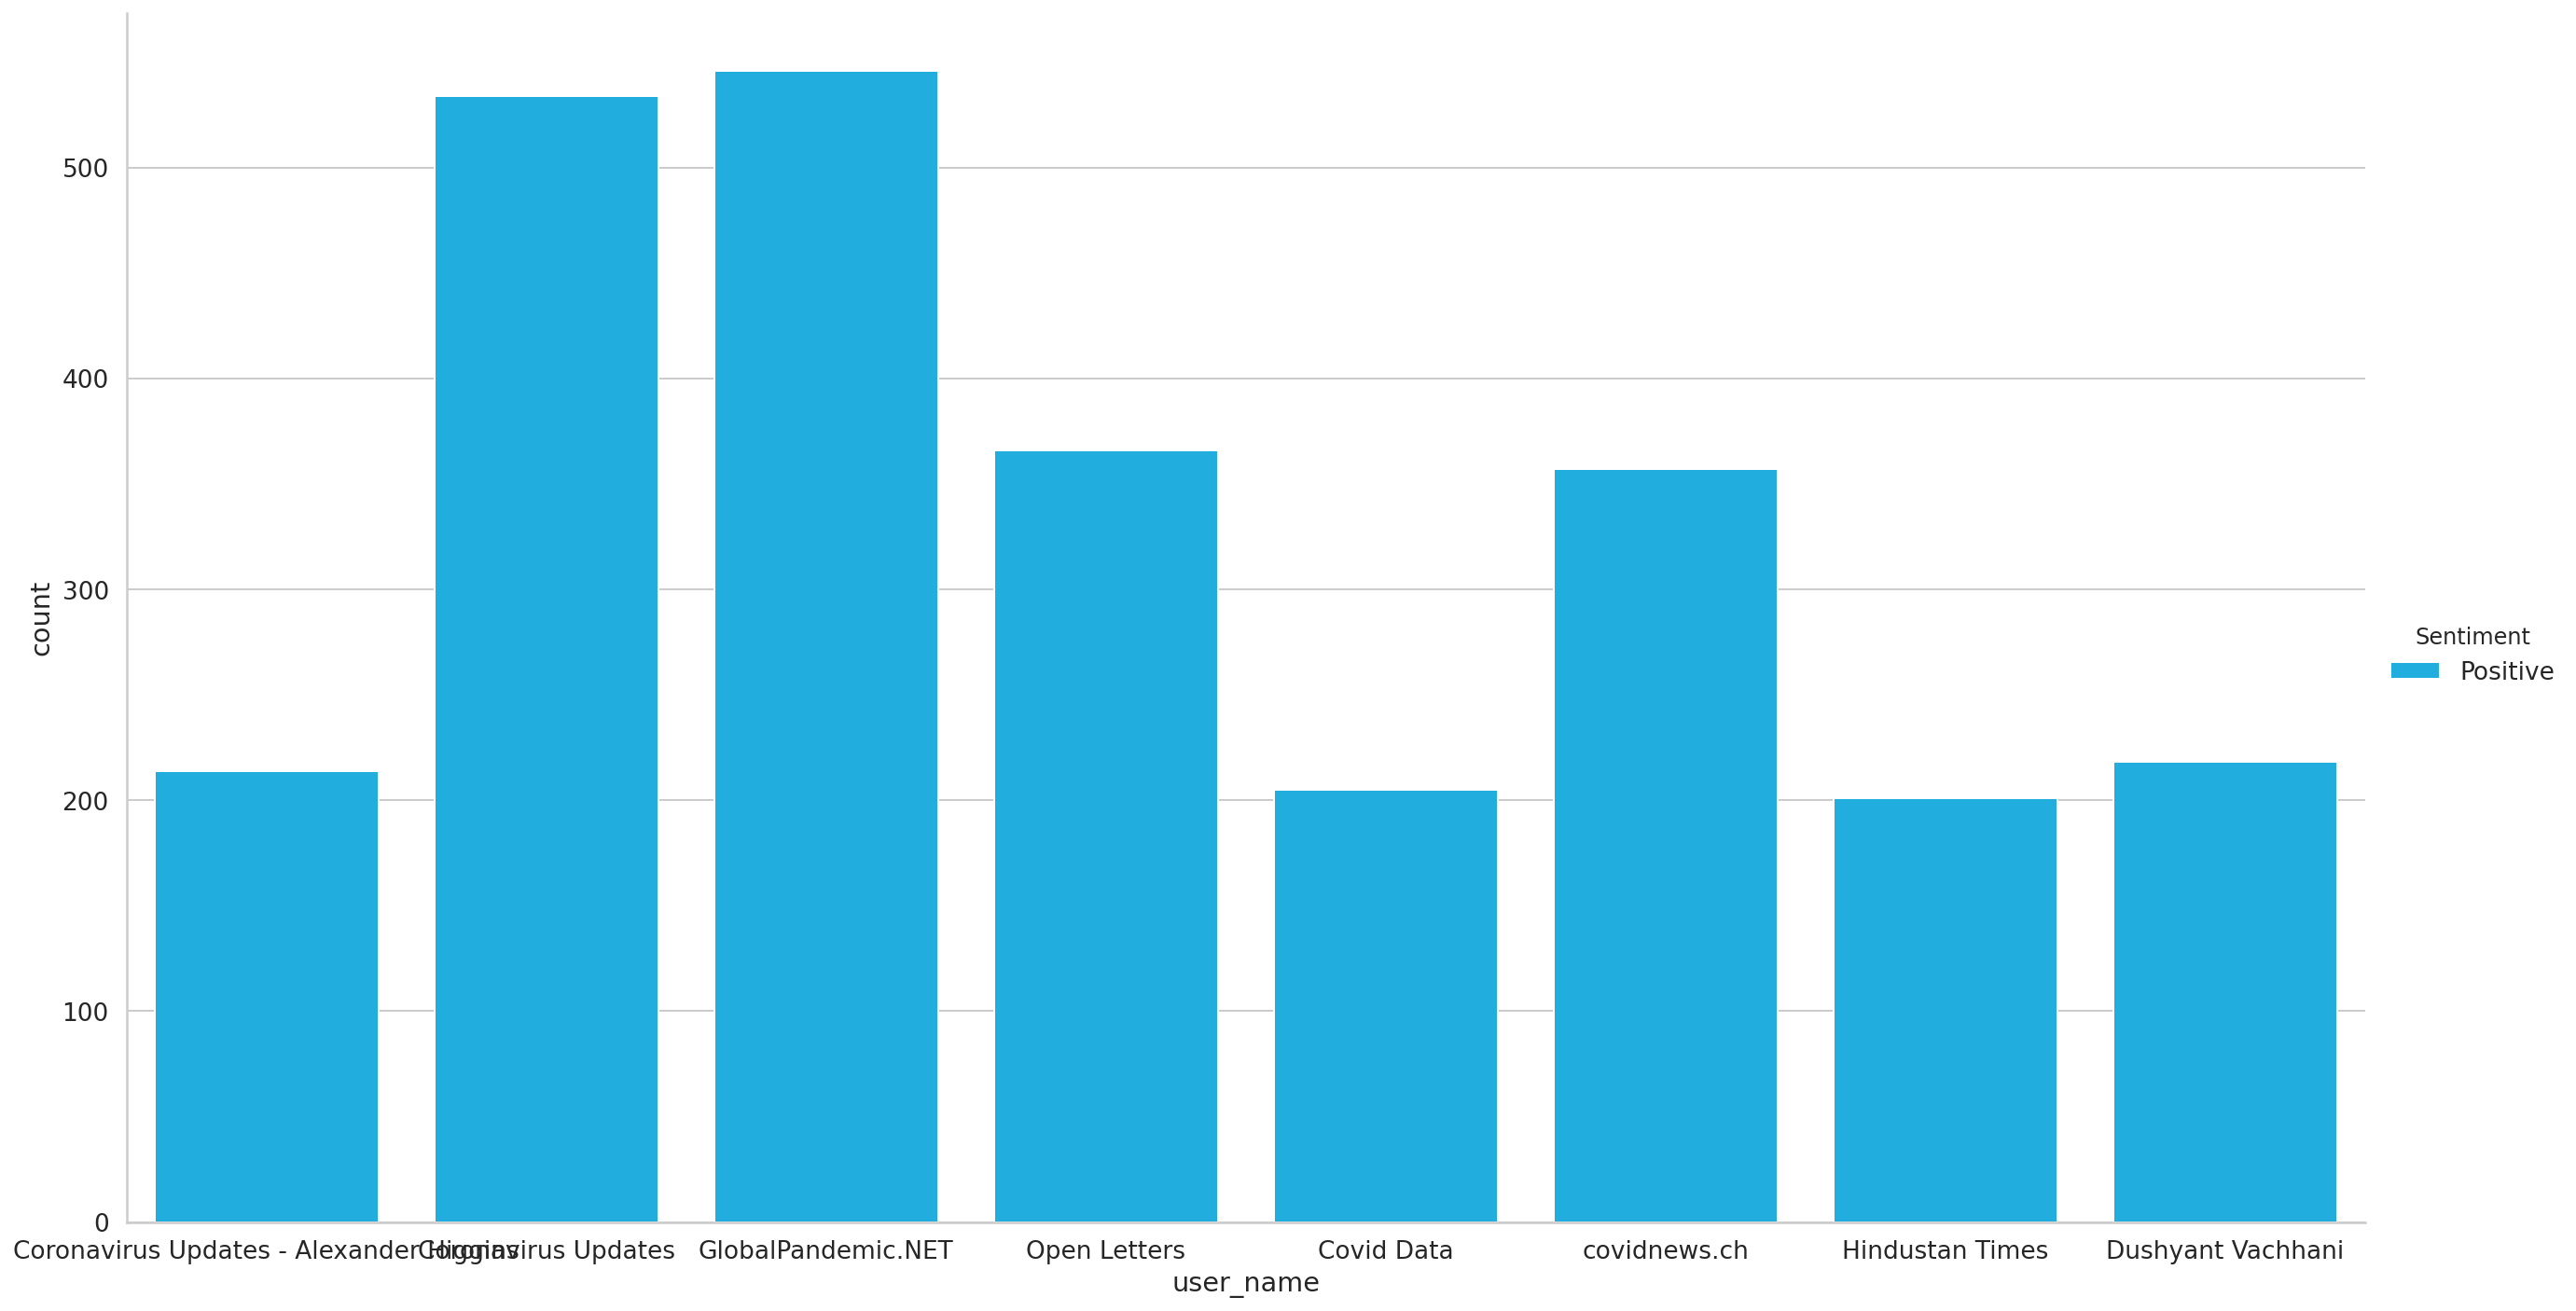

In [ ]:
# Checking top 10 most no of positive tweets by single user
df1 = df[df['Sentiment']=='Positive']
user = df1['user_name'].value_counts()[:8]
df2 = df1[df1['user_name'].isin(user.index)]
sns.catplot(data=df2, kind='count', x='user_name',hue='Sentiment', height=10, aspect=1.8)
# Inference: Most number of positive tweets were done by GlobalPandemic.NET followed by Coronavirus Updates user_names

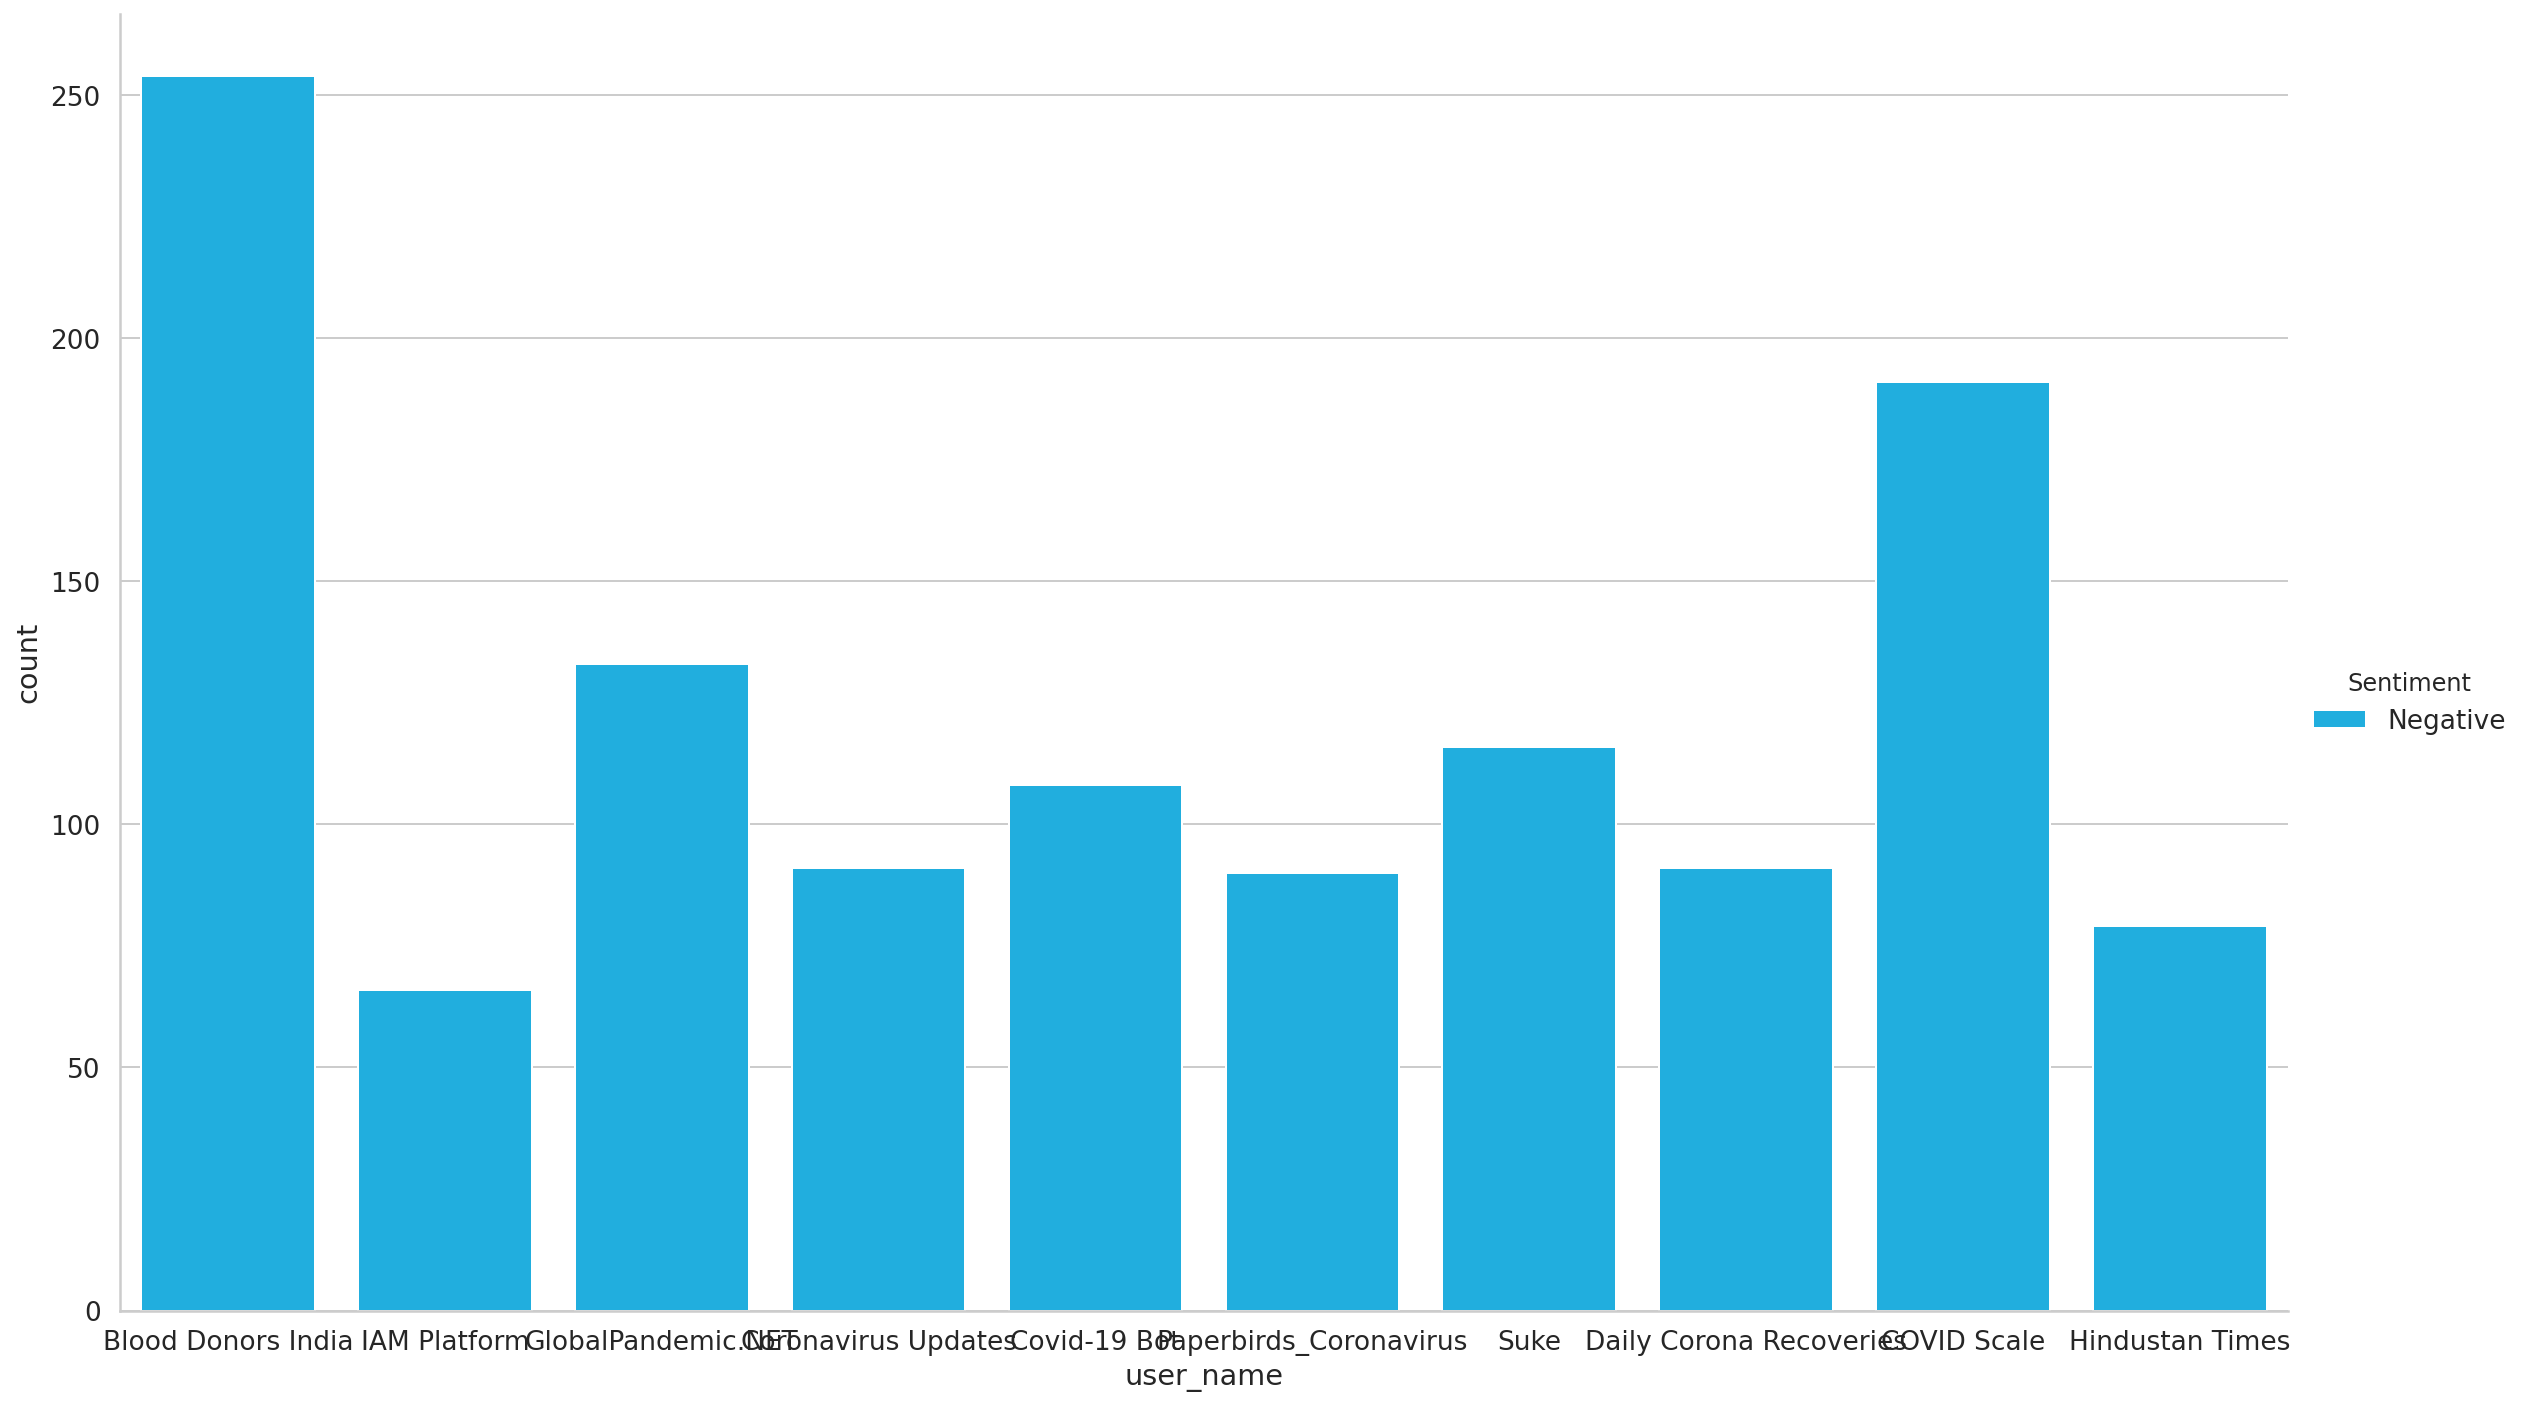

In [ ]:
# Checking top 10 most no of negative tweets by single user
df1 = df[df['Sentiment']=='Negative']
user = df1['user_name'].value_counts()[:10]
df2 = df1[df1['user_name'].isin(user.index)]
sns.catplot(data=df2, kind='count', x='user_name',hue='Sentiment', height=10, aspect=1.6)
# Inference: The most no of negative tweets were from user_name Blood Donors, followed by Covid Scale

# Thank You
With the given time constraints I have done this exploration, thank you for such an amazing task. With more time more indepth analysis could be possible such as training the sentimental analysis model on larger training data, making combinations of more than 2 columns for relations etc.